# Name: Fatima
# Student ID: 20279678

#Machine Learning Predictions of Crime Rates in Wales Assessing the Influence of Temperature Variations

# Import Libraries

In [ ]:
# Standard library imports
import os
import csv

# Data manipulation and analysis
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Geospatial analysis
import geopandas as gpd
from shapely.geometry import Polygon, Point

# Statistical tools
from scipy.stats import gaussian_kde
from matplotlib.colors import Normalize

# Machine learning
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
%cd "/content/drive/My Drive/Colab"

/content/drive/My Drive/Colab


In [ ]:
%cd "/content/drive/My Drive/Colab/dissertation_work"

/content/drive/My Drive/Colab/dissertation_work


# Preprocessing

## Deleting Extra Files

In [ ]:
import os

def delete_files_except_keywords(folder_path, keywords):
    for root, dirs, files in os.walk(folder_path):
        for filename in files:
            if filename.endswith('.csv'):
                file_path = os.path.join(root, filename)
                should_delete = True
                for keyword in keywords:
                    if keyword in filename:
                        should_delete = False
                        break
                if should_delete:
                    os.remove(file_path)
                    print(f"Deleted: {file_path}")
                else:
                    print(f"Retained: {file_path}")

In [ ]:
key_words = ["gwent-street", "north-wales-street", "south-wales-street", "dyfed-powys-street"]
delete_files_except_keywords("crime_data",key_words)

Retained: crime_data/2023-12/2023-12-dyfed-powys-street.csv
Retained: crime_data/2023-12/2023-12-gwent-street.csv
Retained: crime_data/2023-12/2023-12-south-wales-street.csv
Retained: crime_data/2023-12/2023-12-north-wales-street.csv
Retained: crime_data/2023-10/2023-10-dyfed-powys-street.csv
Retained: crime_data/2023-10/2023-10-gwent-street.csv
Retained: crime_data/2023-10/2023-10-north-wales-street.csv
Retained: crime_data/2023-10/2023-10-south-wales-street.csv
Retained: crime_data/2023-11/2023-11-dyfed-powys-street.csv
Retained: crime_data/2023-11/2023-11-gwent-street.csv
Retained: crime_data/2023-11/2023-11-north-wales-street.csv
Retained: crime_data/2023-11/2023-11-south-wales-street.csv
Retained: crime_data/2023-09/2023-09-gwent-street.csv
Retained: crime_data/2023-09/2023-09-dyfed-powys-street.csv
Retained: crime_data/2023-09/2023-09-south-wales-street.csv
Retained: crime_data/2023-09/2023-09-north-wales-street.csv
Retained: crime_data/2023-07/2023-07-dyfed-powys-street.csv
Reta

## Combine Crime Files

In [ ]:
dfs = []
# Define the directory containing the CSV files
directory = 'crime_data'
# Iterate over all files in the directory
for root, dirs, files in os.walk(directory):
    for filename in files:
        if filename.endswith('.csv'):
            # Read the CSV file into a DataFrame
            file_path = os.path.join(root, filename)
            df = pd.read_csv(os.path.join(file_path))
            # Append the DataFrame to the list
            dfs.append(df)

# Concatenate all DataFrames into one
crime_df = pd.concat(dfs, ignore_index=True)

In [ ]:
# saving the file
crime_df.to_csv("crime_data.csv", index=False)

## Reading The Datasets
1. Crime Data
2. Weather Data
3. Cardiff Shape File

### Reading Crime Data

In [ ]:
df_crime = pd.read_csv("crime_data.csv")
df_crime.head()

,Crime ID,Month,Reported by,Falls within,Longitude,Latitude,Location,LSOA code,LSOA name,Crime type,Last outcome category,Context
0,cff403556bc60a6828da354879ce327c2e04555ccd71dc...,2023-12,Dyfed-Powys Police,Dyfed-Powys Police,-3.705231,51.477484,On or near Mary Street,W01001046,Bridgend 018C,Violence and sexual offences,Under investigation,NaN
1,ceea00ecd5e6536abb4ca8966a5dd435388d0232fe29a6...,2023-12,Dyfed-Powys Police,Dyfed-Powys Police,-2.273464,53.599647,On or near Mossfield Close,E01004960,Bury 007E,Violence and sexual offences,Unable to prosecute suspect,NaN
2,ceb8da60966df29bbee9f90a20597d4b3d417de266a8aa...,2023-12,Dyfed-Powys Police,Dyfed-Powys Police,-3.190509,51.593326,On or near Bryn Close,W01001341,Caerphilly 020B,Violence and sexual offences,Under investigation,NaN
3,NaN,2023-12,Dyfed-Powys Police,Dyfed-Powys Police,-4.314915,52.037414,On or near Lewis Street,W01000685,Carmarthenshire 001A,Anti-social behaviour,NaN,NaN
4,8143ec2917cf7e49ca5cb2e9da23c140de9029e1f1ec81...,2023-12,Dyfed-Powys Police,Dyfed-Powys Police,-4.314915,52.037414,On or near Lewis Street,W01000685,Carmarthenshire 001A,Criminal damage and arson,Investigation complete; no suspect identified,NaN


In [ ]:
# Create a GeoDataFrame from the crime DataFrame

gdf_crime = gpd.GeoDataFrame(
    df_crime,
    geometry=gpd.points_from_xy(df_crime.Longitude, df_crime.Latitude),
    crs='EPSG:4326'
)

# Reproject the GeoDataFrame to a different CRS (British National Grid)
gdf_crime = gdf_crime.to_crs(epsg=27700)

In [ ]:
gdf_crime['month_year'] = pd.to_datetime(gdf_crime['Month'], format='%Y-%m').dt.to_period('M')
gdf_crime.head()

,Crime ID,Month,Reported by,Falls within,Longitude,Latitude,Location,LSOA code,LSOA name,Crime type,Last outcome category,Context,geometry,month_year
0,cff403556bc60a6828da354879ce327c2e04555ccd71dc...,2023-12,Dyfed-Powys Police,Dyfed-Powys Police,-3.705231,51.477484,On or near Mary Street,W01001046,Bridgend 018C,Violence and sexual offences,Under investigation,NaN,POINT (281673.977 176770.957),2023-12
1,ceea00ecd5e6536abb4ca8966a5dd435388d0232fe29a6...,2023-12,Dyfed-Powys Police,Dyfed-Powys Police,-2.273464,53.599647,On or near Mossfield Close,E01004960,Bury 007E,Violence and sexual offences,Unable to prosecute suspect,NaN,POINT (381999.973 411488.038),2023-12
2,ceb8da60966df29bbee9f90a20597d4b3d417de266a8aa...,2023-12,Dyfed-Powys Police,Dyfed-Powys Police,-3.190509,51.593326,On or near Bryn Close,W01001341,Caerphilly 020B,Violence and sexual offences,Under investigation,NaN,POINT (317627.988 188947.003),2023-12
3,NaN,2023-12,Dyfed-Powys Police,Dyfed-Powys Police,-4.314915,52.037414,On or near Lewis Street,W01000685,Carmarthenshire 001A,Anti-social behaviour,NaN,NaN,POINT (241314.994 240198.000),2023-12
4,8143ec2917cf7e49ca5cb2e9da23c140de9029e1f1ec81...,2023-12,Dyfed-Powys Police,Dyfed-Powys Police,-4.314915,52.037414,On or near Lewis Street,W01000685,Carmarthenshire 001A,Criminal damage and arson,Investigation complete; no suspect identified,NaN,POINT (241314.994 240198.000),2023-12


### Read and Merge Weather Data for South Wales, North Wales, and Cardiff

In [ ]:
def transform_weather_data(df, start_year, end_year, region_name, column_name):
    """
    Transforms the given weather DataFrame for a specific year range and region.

    Parameters:
    df (pd.DataFrame): The input DataFrame containing weather data.
    start_year (int): The starting year for filtering the data.
    end_year (int): The ending year for filtering the data.
    region_name (str): The name of the region to add to the data.
    column_name (str): The name to use for the value column in the long format.

    Returns:
    pd.DataFrame: A DataFrame in long format with filtered data and added region information.
    """

    # Filter the dataframe for rows where the year is between start_year and end_year (inclusive)
    df_filtered = df[(df['year'] >= start_year) & (df['year'] <= end_year)]

    # Add a new column 'region' with the specified region_name to the filtered dataframe
    df_filtered['region'] = region_name

    # Melt the dataframe to convert from wide format (months as columns) to long format
    # 'id_vars' keeps the 'year' and 'region' columns as identifier variables
    # 'value_vars' specifies the month columns to be unpivoted
    # 'var_name' sets the name of the new column containing the month names
    # 'value_name' sets the name of the new column containing the values from month columns
    df_long = pd.melt(df_filtered, id_vars=['year', 'region'],
                      value_vars=['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'],
                      var_name='month', value_name=column_name)

    # Define a dictionary to map month abbreviations to their corresponding numeric values
    month_map = {'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6, 'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12}

    # Map the month abbreviations in the 'month' column to numeric values using the month_map dictionary
    df_long['month'] = df_long['month'].map(month_map)

    # Return the transformed DataFrame in long format
    return df_long

#### North Wales

In [ ]:
# Read the weather data file for North West England and North Wales, skipping the first 5 rows and using whitespace as the delimiter
df_nw_max = pd.read_csv("weather_data/England_NW_and_N_Wales.txt", skiprows=5, delim_whitespace=True)

# Transform the weather data to filter records from 2018 to 2023,
# specify the region as 'North Wales' and the weather parameter as 'max_temp'
df_nw_max_filtered = transform_weather_data(df_nw_max, 2018, 2023, 'North Wales', 'max_temp')
df_nw_max_filtered.head()

<ipython-input-87-af9c506416e9>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['region'] = region_name


,year,region,month,max_temp
0,2018,North Wales,1,6.7
1,2019,North Wales,1,6.0
2,2020,North Wales,1,8.1
3,2021,North Wales,1,5.0
4,2022,North Wales,1,7.5


In [ ]:
# Read the weather data file for North West England and North Wales (minimum temperature),
# skipping the first 5 rows and using whitespace as the delimiter
df_nw_min = pd.read_csv("weather_data/England_NW_and_N_Wales (minimum temperature).txt", skiprows=5, delim_whitespace=True)
# specify the region as 'North Wales', and the weather parameter as 'min_temp'
df_nw_min_filtered = transform_weather_data(df_nw_min, 2018, 2023, 'North Wales', 'min_temp')
df_nw_min_filtered.head()

<ipython-input-87-af9c506416e9>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['region'] = region_name


,year,region,month,min_temp
0,2018,North Wales,1,1.8
1,2019,North Wales,1,1.2
2,2020,North Wales,1,3.2
3,2021,North Wales,1,-0.1
4,2022,North Wales,1,1.9


In [ ]:
# Merge the filtered maximum temperature and minimum temperature DataFrames
# on the columns 'year', 'region', and 'month'
df_north_wales = pd.merge(df_nw_max_filtered, df_nw_min_filtered, on=['year', 'region', 'month'])
df_north_wales.head()

,year,region,month,max_temp,min_temp
0,2018,North Wales,1,6.7,1.8
1,2019,North Wales,1,6.0,1.2
2,2020,North Wales,1,8.1,3.2
3,2021,North Wales,1,5.0,-0.1
4,2022,North Wales,1,7.5,1.9


#### South Wales

In [ ]:
# Read the weather data file for South West England and South Wales, skipping the first 5 rows and using whitespace as the delimiter
df_sw_max = pd.read_csv("weather_data/England_SW_and_S_Wales.txt", skiprows=5, delim_whitespace=True)
# specify the region as 'South Wales', and the weather parameter as 'max_temp'
df_sw_max_filtered = transform_weather_data(df_sw_max, 2018, 2023, 'South Wales', 'max_temp')
df_sw_max_filtered.head()

<ipython-input-87-af9c506416e9>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['region'] = region_name


,year,region,month,max_temp
0,2018,South Wales,1,8.6
1,2019,South Wales,1,7.2
2,2020,South Wales,1,8.9
3,2021,South Wales,1,6.7
4,2022,South Wales,1,8.5


In [ ]:
# Read the weather data file for South West England and South Wales (minimum temperature),
# skipping the first 5 rows and using whitespace as the delimiter
df_sw_min = pd.read_csv("weather_data/England_SW_and_S_Wales (minimum temperature).txt", skiprows=5, delim_whitespace=True)
# specify the region as 'South Wales', and the weather parameter as 'min_temp'
df_sw_min_filtered = transform_weather_data(df_sw_min, 2018, 2023, 'South Wales', 'min_temp')
df_sw_min_filtered.head()

<ipython-input-87-af9c506416e9>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['region'] = region_name


,year,region,month,min_temp
0,2018,South Wales,1,2.8
1,2019,South Wales,1,2.0
2,2020,South Wales,1,3.7
3,2021,South Wales,1,1.2
4,2022,South Wales,1,2.0


In [ ]:
# Merge the filtered maximum temperature and minimum temperature DataFrames for South Wales
# on the columns 'year', 'region', and 'month'
df_south_wales = pd.merge(df_sw_max_filtered, df_sw_min_filtered, on=['year', 'region', 'month'])
df_south_wales.head()

,year,region,month,max_temp,min_temp
0,2018,South Wales,1,8.6,2.8
1,2019,South Wales,1,7.2,2.0
2,2020,South Wales,1,8.9,3.7
3,2021,South Wales,1,6.7,1.2
4,2022,South Wales,1,8.5,2.0


#### Cardiff

In [ ]:
# Define the column names for the Cardiff weather data
column_names = ['year', 'month', 'max_temp', 'min_temp', 'air_frost_days', 'rainfall_mm', 'sunshine_hours']
# Read the Cardiff weather data file, skipping the first 7 rows, using the defined column names,
# specifying whitespace as the delimiter, and skipping lines with bad data
df_cardiff_weather = pd.read_csv("weather_data/cardiffdata.txt", skiprows=7, header=None, names=column_names, delim_whitespace=True, on_bad_lines='skip')
df_cardiff_weather.head()

,year,month,max_temp,min_temp,air_frost_days,rainfall_mm,sunshine_hours
0,1977,9,18.3,8.1,0,48.6,117.9
1,1977,10,15.4,9.0,0,76.0,80.4
2,1977,11,10.3,4.7,4,147.9,76.4
3,1977,12,9.6,4.6,2,88.0,25.6
4,1978,1,7.5,2.0,6,134.1,64.7


In [ ]:
df_cardiff_weather['year'] = df_cardiff_weather['year'].astype(int)

# Convert 'tmax' and 'tmin' columns to numeric, coercing errors to NaN
df_cardiff_weather['max_temp'] = pd.to_numeric(df_cardiff_weather['max_temp'], errors='coerce')
df_cardiff_weather['min_temp'] = pd.to_numeric(df_cardiff_weather['min_temp'], errors='coerce')

# Filter the data for years between 2018 and 2023
df_filtered = df_cardiff_weather[(df_cardiff_weather['year'] >= 2018) & (df_cardiff_weather['year'] <= 2023)]
df_filtered['region'] = "Cardiff"
df_filtered = df_filtered[['year', 'region', 'month', 'max_temp', 'min_temp']]

# Display the head of the resulting dataframe
df_filtered.head()

<ipython-input-95-4db4b296457a>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['region'] = "Cardiff"


,year,region,month,max_temp,min_temp
484,2018,Cardiff,1,9.4,2.7
485,2018,Cardiff,2,7.5,0.8
486,2018,Cardiff,3,9.1,2.5
487,2018,Cardiff,4,14.0,7.2
488,2018,Cardiff,5,19.0,8.8


#### Merging weather files

In [ ]:
# Concatenate the filtered data frames vertically
df_weather = pd.concat([df_filtered, df_north_wales, df_south_wales], ignore_index=True)

# Print the combined DataFrame
df_weather.head()

,year,region,month,max_temp,min_temp
0,2018,Cardiff,1,9.4,2.7
1,2018,Cardiff,2,7.5,0.8
2,2018,Cardiff,3,9.1,2.5
3,2018,Cardiff,4,14.0,7.2
4,2018,Cardiff,5,19.0,8.8


In [ ]:
df_weather['month_year'] = pd.to_datetime(df_weather[['year', 'month']].assign(day=1)).dt.to_period('M')
df_weather.head()

,year,region,month,max_temp,min_temp,month_year
0,2018,Cardiff,1,9.4,2.7,2018-01
1,2018,Cardiff,2,7.5,0.8,2018-02
2,2018,Cardiff,3,9.1,2.5,2018-03
3,2018,Cardiff,4,14.0,7.2,2018-04
4,2018,Cardiff,5,19.0,8.8,2018-05


In [ ]:
df_weather["region"].unique()

array(['Cardiff', 'North Wales', 'South Wales'], dtype=object)

### Reading the Wales shp

In [ ]:
#Reading the shape (shp) file of Wales
gdf_wales = gpd.read_file("shps_wales/NAWC_Dec_2016_GCB_in_Wales_2022_1344215331916956270/NAWC_Dec_2016_GCB_in_Wales.shp")
gdf_wales.head()

,nawc16cd,nawc16nm,bng_e,bng_n,long,lat,GlobalID,geometry
0,W09000001,Ynys Mon,245222,378346,-4.32291,53.279449,22944cef-3263-4a62-96a8-160ccbd1a012,"MULTIPOLYGON (((239100.098 395170.703, 239332...."
1,W09000002,Arfon,256909,361593,-4.14025,53.132252,81a48eca-8a46-4006-af34-2a52105ae8c1,"POLYGON ((266772.197 374236.195, 266970.202 37..."
2,W09000003,Aberconwy,276098,360888,-3.85333,53.130718,b26b8bfe-808b-4fd3-9b76-f888615f245a,"POLYGON ((275693.699 384499.797, 276142.997 38..."
3,W09000004,Clwyd West,297156,361691,-3.53898,53.142422,0b893955-c401-4aae-8787-c0ce31cdea2f,"POLYGON ((284318.297 380731.796, 284326.303 38..."
4,W09000005,Vale of Clwyd,306235,374013,-3.40692,53.254822,d0d70720-ea72-4c0d-a1a7-f6b89fd35f60,"MULTIPOLYGON (((308957.104 384062.902, 309052...."


#### Merging the SHP into regions: North Wales, South Wales, and Cardiff by combining areas

In [ ]:
# These lists contain the names of areas that belong to North Wales and Cardiff
north_wales = [
    'Aberconwy', 'Alyn and Deeside', 'Arfon', 'Clwyd South', 'Clwyd West',
    'Delyn', 'Dwyfor Meirionnydd', 'Wrexham', 'Ynys Mon', 'Vale of Clwyd'
]

cardiff = ['Cardiff Central', 'Cardiff North', 'Cardiff West']
# Function to label each area with its region (North Wales, Cardiff, or South Wales)
# Apply region labels
def label_region(constituency):
    if constituency in north_wales:
        return 'North Wales'
    elif constituency in cardiff:
        return 'Cardiff'
    else:
        return 'South Wales'
# Apply the label_region function to each row in the gdf_wales DataFrame
# The 'nawc16nm' column contains the names of the constituencies
gdf_wales['region'] = gdf_wales['nawc16nm'].apply(label_region)
gdf_wales.head()

,nawc16cd,nawc16nm,bng_e,bng_n,long,lat,GlobalID,geometry,region
0,W09000001,Ynys Mon,245222,378346,-4.32291,53.279449,22944cef-3263-4a62-96a8-160ccbd1a012,"MULTIPOLYGON (((239100.098 395170.703, 239332....",North Wales
1,W09000002,Arfon,256909,361593,-4.14025,53.132252,81a48eca-8a46-4006-af34-2a52105ae8c1,"POLYGON ((266772.197 374236.195, 266970.202 37...",North Wales
2,W09000003,Aberconwy,276098,360888,-3.85333,53.130718,b26b8bfe-808b-4fd3-9b76-f888615f245a,"POLYGON ((275693.699 384499.797, 276142.997 38...",North Wales
3,W09000004,Clwyd West,297156,361691,-3.53898,53.142422,0b893955-c401-4aae-8787-c0ce31cdea2f,"POLYGON ((284318.297 380731.796, 284326.303 38...",North Wales
4,W09000005,Vale of Clwyd,306235,374013,-3.40692,53.254822,d0d70720-ea72-4c0d-a1a7-f6b89fd35f60,"MULTIPOLYGON (((308957.104 384062.902, 309052....",North Wales


In [ ]:
# Dissolve the geometries in the GeoDataFrame by the 'region' column
# This means combining all the geometries (shapes) that belong to the same region (North Wales, Cardiff, South Wales)
# The 'as_index=False' argument ensures that the 'region' column is kept as a regular column and not set as the index
gdf_wales = gdf_wales.dissolve(by='region', as_index=False)
# Display the first few rows of the GeoDataFrame to verify the dissolve operation
gdf_wales.head()

,region,geometry,nawc16cd,nawc16nm,bng_e,bng_n,long,lat,GlobalID
0,Cardiff,"POLYGON ((321491.798 181357.596, 321554.700 18...",W09000029,Cardiff West,312437,178939,-3.26294,51.502571,8a8bd5ef-82f9-4856-948e-427fbb4b4d6d
1,North Wales,"MULTIPOLYGON (((210886.299 321418.304, 210978....",W09000001,Ynys Mon,245222,378346,-4.32291,53.279449,22944cef-3263-4a62-96a8-160ccbd1a012
2,South Wales,"MULTIPOLYGON (((172755.200 204729.196, 172710....",W09000011,Montgomeryshire,301718,304472,-3.45350,52.629089,d7b0ee14-0a3b-4e1e-a1c4-444b3e624623


In [ ]:
gdf_wales.crs

<Projected CRS: EPSG:27700>
Name: OSGB36 / British National Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: United Kingdom (UK) - offshore to boundary of UKCS within 49°45'N to 61°N and 9°W to 2°E; onshore Great Britain (England, Wales and Scotland). Isle of Man onshore.
- bounds: (-9.01, 49.75, 2.01, 61.01)
Coordinate Operation:
- name: British National Grid
- method: Transverse Mercator
Datum: Ordnance Survey of Great Britain 1936
- Ellipsoid: Airy 1830
- Prime Meridian: Greenwich

In [ ]:
gdf_wales = gdf_wales.to_crs(epsg=27700)

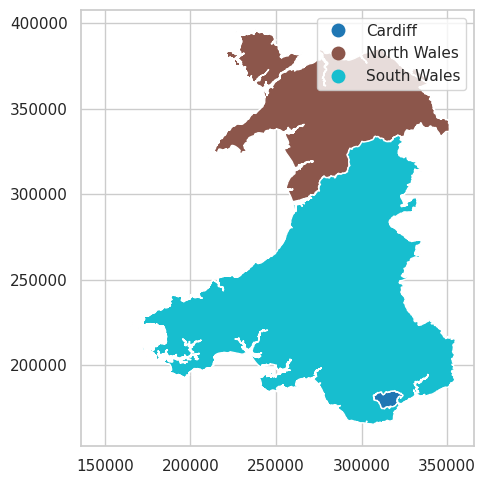

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

# Plot the GeoDataFrame
gdf_wales.plot(column='region', legend=True, ax=ax)

# Adjust the layout and legend
plt.tight_layout()

# Show the plot
plt.show()

## Merging the datasets

### Crime and wales shp

In [ ]:
gdf_crime_shp = gpd.sjoin(gdf_crime, gdf_wales[['geometry', 'region']], how='left', predicate='within')
gdf_crime_shp.head()

,Crime ID,Month,Reported by,Falls within,Longitude,Latitude,Location,LSOA code,LSOA name,Crime type,Last outcome category,Context,geometry,month_year,index_right,region
0,cff403556bc60a6828da354879ce327c2e04555ccd71dc...,2023-12,Dyfed-Powys Police,Dyfed-Powys Police,-3.705231,51.477484,On or near Mary Street,W01001046,Bridgend 018C,Violence and sexual offences,Under investigation,NaN,POINT (281673.977 176770.957),2023-12,2.0,South Wales
1,ceea00ecd5e6536abb4ca8966a5dd435388d0232fe29a6...,2023-12,Dyfed-Powys Police,Dyfed-Powys Police,-2.273464,53.599647,On or near Mossfield Close,E01004960,Bury 007E,Violence and sexual offences,Unable to prosecute suspect,NaN,POINT (381999.973 411488.038),2023-12,NaN,NaN
2,ceb8da60966df29bbee9f90a20597d4b3d417de266a8aa...,2023-12,Dyfed-Powys Police,Dyfed-Powys Police,-3.190509,51.593326,On or near Bryn Close,W01001341,Caerphilly 020B,Violence and sexual offences,Under investigation,NaN,POINT (317627.988 188947.003),2023-12,2.0,South Wales
3,NaN,2023-12,Dyfed-Powys Police,Dyfed-Powys Police,-4.314915,52.037414,On or near Lewis Street,W01000685,Carmarthenshire 001A,Anti-social behaviour,NaN,NaN,POINT (241314.994 240198.000),2023-12,2.0,South Wales
4,8143ec2917cf7e49ca5cb2e9da23c140de9029e1f1ec81...,2023-12,Dyfed-Powys Police,Dyfed-Powys Police,-4.314915,52.037414,On or near Lewis Street,W01000685,Carmarthenshire 001A,Criminal damage and arson,Investigation complete; no suspect identified,NaN,POINT (241314.994 240198.000),2023-12,2.0,South Wales


In [ ]:
gdf_crime['region'] = gdf_crime_shp['region']

In [ ]:
gdf_crime = gdf_crime[gdf_crime['region'].notnull()]
gdf_crime.head()

,Crime ID,Month,Reported by,Falls within,Longitude,Latitude,Location,LSOA code,LSOA name,Crime type,Last outcome category,Context,geometry,month_year,region
0,cff403556bc60a6828da354879ce327c2e04555ccd71dc...,2023-12,Dyfed-Powys Police,Dyfed-Powys Police,-3.705231,51.477484,On or near Mary Street,W01001046,Bridgend 018C,Violence and sexual offences,Under investigation,NaN,POINT (281673.977 176770.957),2023-12,South Wales
2,ceb8da60966df29bbee9f90a20597d4b3d417de266a8aa...,2023-12,Dyfed-Powys Police,Dyfed-Powys Police,-3.190509,51.593326,On or near Bryn Close,W01001341,Caerphilly 020B,Violence and sexual offences,Under investigation,NaN,POINT (317627.988 188947.003),2023-12,South Wales
3,NaN,2023-12,Dyfed-Powys Police,Dyfed-Powys Police,-4.314915,52.037414,On or near Lewis Street,W01000685,Carmarthenshire 001A,Anti-social behaviour,NaN,NaN,POINT (241314.994 240198.000),2023-12,South Wales
4,8143ec2917cf7e49ca5cb2e9da23c140de9029e1f1ec81...,2023-12,Dyfed-Powys Police,Dyfed-Powys Police,-4.314915,52.037414,On or near Lewis Street,W01000685,Carmarthenshire 001A,Criminal damage and arson,Investigation complete; no suspect identified,NaN,POINT (241314.994 240198.000),2023-12,South Wales
5,5cdb8c29fe0e12ed35b197c6cb202ea04e9f2cb009ca64...,2023-12,Dyfed-Powys Police,Dyfed-Powys Police,-4.265691,51.992178,On or near Golwg Yr Ogof,W01000685,Carmarthenshire 001A,Criminal damage and arson,Investigation complete; no suspect identified,NaN,POINT (244533.990 235061.053),2023-12,South Wales


In [ ]:
gdf_crime_weather = gdf_crime_shp[gdf_crime_shp['region'].notnull()]
# Display the first few rows of the filtered data
gdf_crime_weather.head()

,Crime ID,Month,Reported by,Falls within,Longitude,Latitude,Location,LSOA code,LSOA name,Crime type,Last outcome category,Context,geometry,month_year,index_right,region
0,cff403556bc60a6828da354879ce327c2e04555ccd71dc...,2023-12,Dyfed-Powys Police,Dyfed-Powys Police,-3.705231,51.477484,On or near Mary Street,W01001046,Bridgend 018C,Violence and sexual offences,Under investigation,NaN,POINT (281673.977 176770.957),2023-12,2.0,South Wales
2,ceb8da60966df29bbee9f90a20597d4b3d417de266a8aa...,2023-12,Dyfed-Powys Police,Dyfed-Powys Police,-3.190509,51.593326,On or near Bryn Close,W01001341,Caerphilly 020B,Violence and sexual offences,Under investigation,NaN,POINT (317627.988 188947.003),2023-12,2.0,South Wales
3,NaN,2023-12,Dyfed-Powys Police,Dyfed-Powys Police,-4.314915,52.037414,On or near Lewis Street,W01000685,Carmarthenshire 001A,Anti-social behaviour,NaN,NaN,POINT (241314.994 240198.000),2023-12,2.0,South Wales
4,8143ec2917cf7e49ca5cb2e9da23c140de9029e1f1ec81...,2023-12,Dyfed-Powys Police,Dyfed-Powys Police,-4.314915,52.037414,On or near Lewis Street,W01000685,Carmarthenshire 001A,Criminal damage and arson,Investigation complete; no suspect identified,NaN,POINT (241314.994 240198.000),2023-12,2.0,South Wales
5,5cdb8c29fe0e12ed35b197c6cb202ea04e9f2cb009ca64...,2023-12,Dyfed-Powys Police,Dyfed-Powys Police,-4.265691,51.992178,On or near Golwg Yr Ogof,W01000685,Carmarthenshire 001A,Criminal damage and arson,Investigation complete; no suspect identified,NaN,POINT (244533.990 235061.053),2023-12,2.0,South Wales


### With Weather Data

In [ ]:
# Define a function to map months to seasons
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Autumn'

In [ ]:
gdf_crime_weather = pd.merge(gdf_crime_weather, df_weather, on=['month_year', 'region'], how='left', suffixes=('_crime', '_weather'))
gdf_crime_weather.head()

,Crime ID,Month,Reported by,Falls within,Longitude,Latitude,Location,LSOA code,LSOA name,Crime type,Last outcome category,Context,geometry,month_year,index_right,region,year,month,max_temp,min_temp
0,cff403556bc60a6828da354879ce327c2e04555ccd71dc...,2023-12,Dyfed-Powys Police,Dyfed-Powys Police,-3.705231,51.477484,On or near Mary Street,W01001046,Bridgend 018C,Violence and sexual offences,Under investigation,NaN,POINT (281673.977 176770.957),2023-12,2.0,South Wales,2023,12,10.1,5.5
1,ceb8da60966df29bbee9f90a20597d4b3d417de266a8aa...,2023-12,Dyfed-Powys Police,Dyfed-Powys Police,-3.190509,51.593326,On or near Bryn Close,W01001341,Caerphilly 020B,Violence and sexual offences,Under investigation,NaN,POINT (317627.988 188947.003),2023-12,2.0,South Wales,2023,12,10.1,5.5
2,NaN,2023-12,Dyfed-Powys Police,Dyfed-Powys Police,-4.314915,52.037414,On or near Lewis Street,W01000685,Carmarthenshire 001A,Anti-social behaviour,NaN,NaN,POINT (241314.994 240198.000),2023-12,2.0,South Wales,2023,12,10.1,5.5
3,8143ec2917cf7e49ca5cb2e9da23c140de9029e1f1ec81...,2023-12,Dyfed-Powys Police,Dyfed-Powys Police,-4.314915,52.037414,On or near Lewis Street,W01000685,Carmarthenshire 001A,Criminal damage and arson,Investigation complete; no suspect identified,NaN,POINT (241314.994 240198.000),2023-12,2.0,South Wales,2023,12,10.1,5.5
4,5cdb8c29fe0e12ed35b197c6cb202ea04e9f2cb009ca64...,2023-12,Dyfed-Powys Police,Dyfed-Powys Police,-4.265691,51.992178,On or near Golwg Yr Ogof,W01000685,Carmarthenshire 001A,Criminal damage and arson,Investigation complete; no suspect identified,NaN,POINT (244533.990 235061.053),2023-12,2.0,South Wales,2023,12,10.1,5.5


In [ ]:
# Assuming 'Month' column is in 'YYYY-MM' format, extract the month part
#gdf_crime_weather['month'] = pd.to_datetime(gdf_crime_weather['Month']).dt.month
# Convert 'Month' column to datetime format
gdf_crime_weather['month_year'] = pd.to_datetime(gdf_crime_weather['Month'], format='%Y-%m')
# Extract month name and year from 'month_year' column

gdf_crime_weather['month_name'] = gdf_crime_weather['month_year'].dt.month_name()
gdf_crime_weather['year'] = gdf_crime_weather['month_year'].dt.year
gdf_crime_weather.head()

# Apply the season mapping function to the 'month' column
gdf_crime_weather['Season'] = gdf_crime_weather['month'].apply(get_season)

# Display the updated DataFrame
# print(crime_weather_merged_data[['Month', 'month', 'Season']].head())
gdf_crime_weather.head()

,Crime ID,Month,Reported by,Falls within,Longitude,Latitude,Location,LSOA code,LSOA name,Crime type,...,geometry,month_year,index_right,region,year,month,max_temp,min_temp,month_name,Season
0,cff403556bc60a6828da354879ce327c2e04555ccd71dc...,2023-12,Dyfed-Powys Police,Dyfed-Powys Police,-3.705231,51.477484,On or near Mary Street,W01001046,Bridgend 018C,Violence and sexual offences,...,POINT (281673.977 176770.957),2023-12-01,2.0,South Wales,2023,12,10.1,5.5,December,Winter
1,ceb8da60966df29bbee9f90a20597d4b3d417de266a8aa...,2023-12,Dyfed-Powys Police,Dyfed-Powys Police,-3.190509,51.593326,On or near Bryn Close,W01001341,Caerphilly 020B,Violence and sexual offences,...,POINT (317627.988 188947.003),2023-12-01,2.0,South Wales,2023,12,10.1,5.5,December,Winter
2,NaN,2023-12,Dyfed-Powys Police,Dyfed-Powys Police,-4.314915,52.037414,On or near Lewis Street,W01000685,Carmarthenshire 001A,Anti-social behaviour,...,POINT (241314.994 240198.000),2023-12-01,2.0,South Wales,2023,12,10.1,5.5,December,Winter
3,8143ec2917cf7e49ca5cb2e9da23c140de9029e1f1ec81...,2023-12,Dyfed-Powys Police,Dyfed-Powys Police,-4.314915,52.037414,On or near Lewis Street,W01000685,Carmarthenshire 001A,Criminal damage and arson,...,POINT (241314.994 240198.000),2023-12-01,2.0,South Wales,2023,12,10.1,5.5,December,Winter
4,5cdb8c29fe0e12ed35b197c6cb202ea04e9f2cb009ca64...,2023-12,Dyfed-Powys Police,Dyfed-Powys Police,-4.265691,51.992178,On or near Golwg Yr Ogof,W01000685,Carmarthenshire 001A,Criminal damage and arson,...,POINT (244533.990 235061.053),2023-12-01,2.0,South Wales,2023,12,10.1,5.5,December,Winter


In [ ]:
def categorize_year(year):
    if year in [2018, 2019]:
        return 'precovid'
    elif year in [2020, 2021]:
        return 'covid'
    elif year in [2022, 2023]:
        return 'post covid'
    else:
        return 'unknown'

In [ ]:
gdf_crime_weather['period'] = gdf_crime_weather['year'].apply(categorize_year)
gdf_crime_weather.head()

,Crime ID,Month,Reported by,Falls within,Longitude,Latitude,Location,LSOA code,LSOA name,Crime type,...,month_year,index_right,region,year,month,max_temp,min_temp,month_name,Season,period
0,cff403556bc60a6828da354879ce327c2e04555ccd71dc...,2023-12,Dyfed-Powys Police,Dyfed-Powys Police,-3.705231,51.477484,On or near Mary Street,W01001046,Bridgend 018C,Violence and sexual offences,...,2023-12-01,2.0,South Wales,2023,12,10.1,5.5,December,Winter,post covid
1,ceb8da60966df29bbee9f90a20597d4b3d417de266a8aa...,2023-12,Dyfed-Powys Police,Dyfed-Powys Police,-3.190509,51.593326,On or near Bryn Close,W01001341,Caerphilly 020B,Violence and sexual offences,...,2023-12-01,2.0,South Wales,2023,12,10.1,5.5,December,Winter,post covid
2,NaN,2023-12,Dyfed-Powys Police,Dyfed-Powys Police,-4.314915,52.037414,On or near Lewis Street,W01000685,Carmarthenshire 001A,Anti-social behaviour,...,2023-12-01,2.0,South Wales,2023,12,10.1,5.5,December,Winter,post covid
3,8143ec2917cf7e49ca5cb2e9da23c140de9029e1f1ec81...,2023-12,Dyfed-Powys Police,Dyfed-Powys Police,-4.314915,52.037414,On or near Lewis Street,W01000685,Carmarthenshire 001A,Criminal damage and arson,...,2023-12-01,2.0,South Wales,2023,12,10.1,5.5,December,Winter,post covid
4,5cdb8c29fe0e12ed35b197c6cb202ea04e9f2cb009ca64...,2023-12,Dyfed-Powys Police,Dyfed-Powys Police,-4.265691,51.992178,On or near Golwg Yr Ogof,W01000685,Carmarthenshire 001A,Criminal damage and arson,...,2023-12-01,2.0,South Wales,2023,12,10.1,5.5,December,Winter,post covid


In [ ]:
gdf_crime_weather['Season'].unique()

array(['Winter', 'Autumn', 'Summer', 'Spring'], dtype=object)

## Percentage of missing data

In [ ]:
# Calculate Missing Data Percentage
gdf_crime_weather.isna().sum()/len(gdf_crime_weather)*100

,0
Crime ID,22.445393
Month,0.000000
Reported by,0.000000
Falls within,0.000000
Longitude,0.000000
Latitude,0.000000
Location,0.000000
LSOA code,0.000000
LSOA name,0.000000
Crime type,0.000000


In [ ]:
gdf_crime_weather.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1884106 entries, 0 to 1884105
Data columns (total 23 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   Crime ID               object        
 1   Month                  object        
 2   Reported by            object        
 3   Falls within           object        
 4   Longitude              float64       
 5   Latitude               float64       
 6   Location               object        
 7   LSOA code              object        
 8   LSOA name              object        
 9   Crime type             object        
 10  Last outcome category  object        
 11  Context                float64       
 12  geometry               geometry      
 13  month_year             datetime64[ns]
 14  index_right            float64       
 15  region                 object        
 16  year                   int32         
 17  month                  int64         
 18  max_temp      

# Exploratory Data Analysis

## Crime

In [ ]:
# Convert 'Month' column to datetime format
gdf_crime_weather['month_year'] = pd.to_datetime(gdf_crime_weather['Month'], format='%Y-%m')

In [ ]:
# Extract month name and year from 'month_year' column

gdf_crime_weather['month_name'] = gdf_crime_weather['month_year'].dt.month_name()
gdf_crime_weather['year'] = gdf_crime_weather['month_year'].dt.year
gdf_crime_weather.head()

,Crime ID,Month,Reported by,Falls within,Longitude,Latitude,Location,LSOA code,LSOA name,Crime type,...,month_year,index_right,region,year,month,max_temp,min_temp,month_name,Season,period
0,cff403556bc60a6828da354879ce327c2e04555ccd71dc...,2023-12,Dyfed-Powys Police,Dyfed-Powys Police,-3.705231,51.477484,On or near Mary Street,W01001046,Bridgend 018C,Violence and sexual offences,...,2023-12-01,2.0,South Wales,2023,12,10.1,5.5,December,Winter,post covid
1,ceb8da60966df29bbee9f90a20597d4b3d417de266a8aa...,2023-12,Dyfed-Powys Police,Dyfed-Powys Police,-3.190509,51.593326,On or near Bryn Close,W01001341,Caerphilly 020B,Violence and sexual offences,...,2023-12-01,2.0,South Wales,2023,12,10.1,5.5,December,Winter,post covid
2,NaN,2023-12,Dyfed-Powys Police,Dyfed-Powys Police,-4.314915,52.037414,On or near Lewis Street,W01000685,Carmarthenshire 001A,Anti-social behaviour,...,2023-12-01,2.0,South Wales,2023,12,10.1,5.5,December,Winter,post covid
3,8143ec2917cf7e49ca5cb2e9da23c140de9029e1f1ec81...,2023-12,Dyfed-Powys Police,Dyfed-Powys Police,-4.314915,52.037414,On or near Lewis Street,W01000685,Carmarthenshire 001A,Criminal damage and arson,...,2023-12-01,2.0,South Wales,2023,12,10.1,5.5,December,Winter,post covid
4,5cdb8c29fe0e12ed35b197c6cb202ea04e9f2cb009ca64...,2023-12,Dyfed-Powys Police,Dyfed-Powys Police,-4.265691,51.992178,On or near Golwg Yr Ogof,W01000685,Carmarthenshire 001A,Criminal damage and arson,...,2023-12-01,2.0,South Wales,2023,12,10.1,5.5,December,Winter,post covid


### Crime Count by Type Over Years

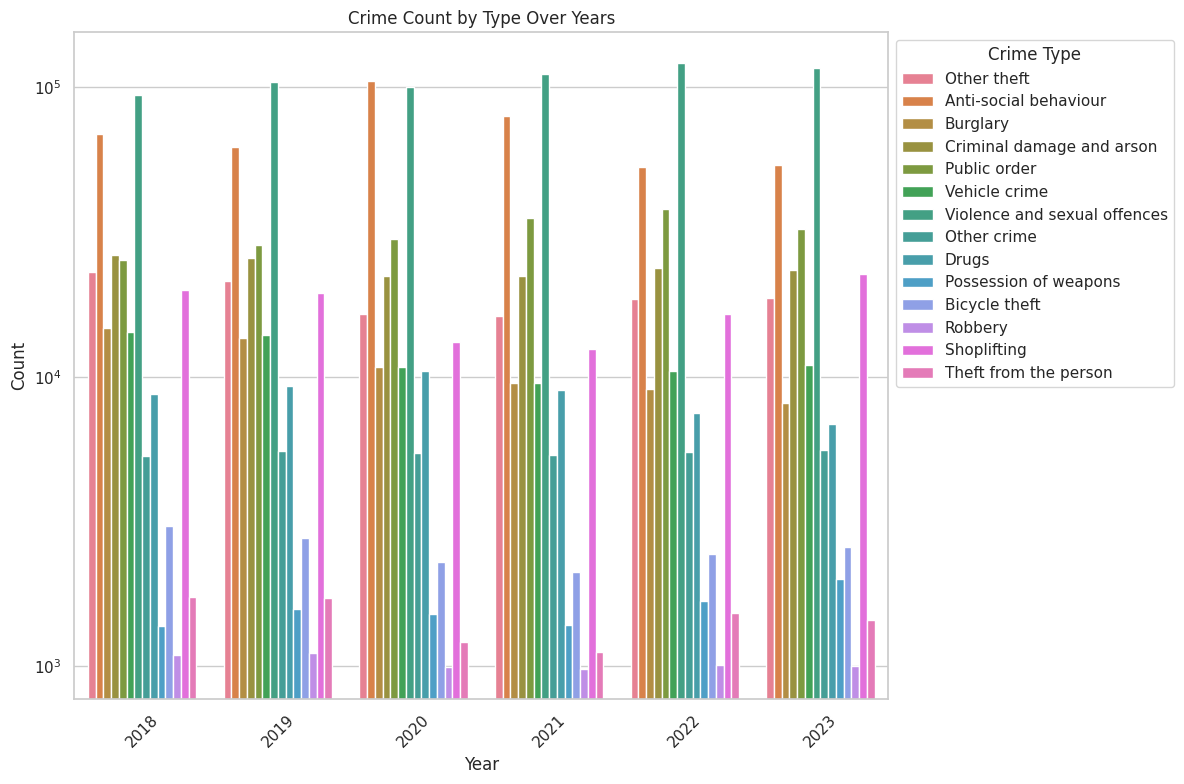

In [ ]:
plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")
sns.countplot(x='year', hue='Crime type', data=gdf_crime_weather)
plt.title('Crime Count by Type Over Years')
plt.xlabel('Year')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Crime Type', bbox_to_anchor=(1, 1))
plt.yscale('log')
plt.tight_layout()
plt.show()

This bar chart illustrates the count of various crime types reported from 2018 to 2023. The x-axis represents the years, and the y-axis indicates the crime counts, with different colors depicting different crime types. Violence and sexual offences consistently have the highest counts across all years, indicating a persistent issue. Other notable crime types include Anti-social behaviour, Public order, and Criminal damage and arson, each showing significant but lower counts. There is a noticeable fluctuation in crime counts over the years, with some reduction seen in 2020 and 2021, likely due to the impact of COVID-19 lockdowns. The chart helps in understanding crime trends and identifying areas needing targeted intervention.

### Crime Count by Type Over Months

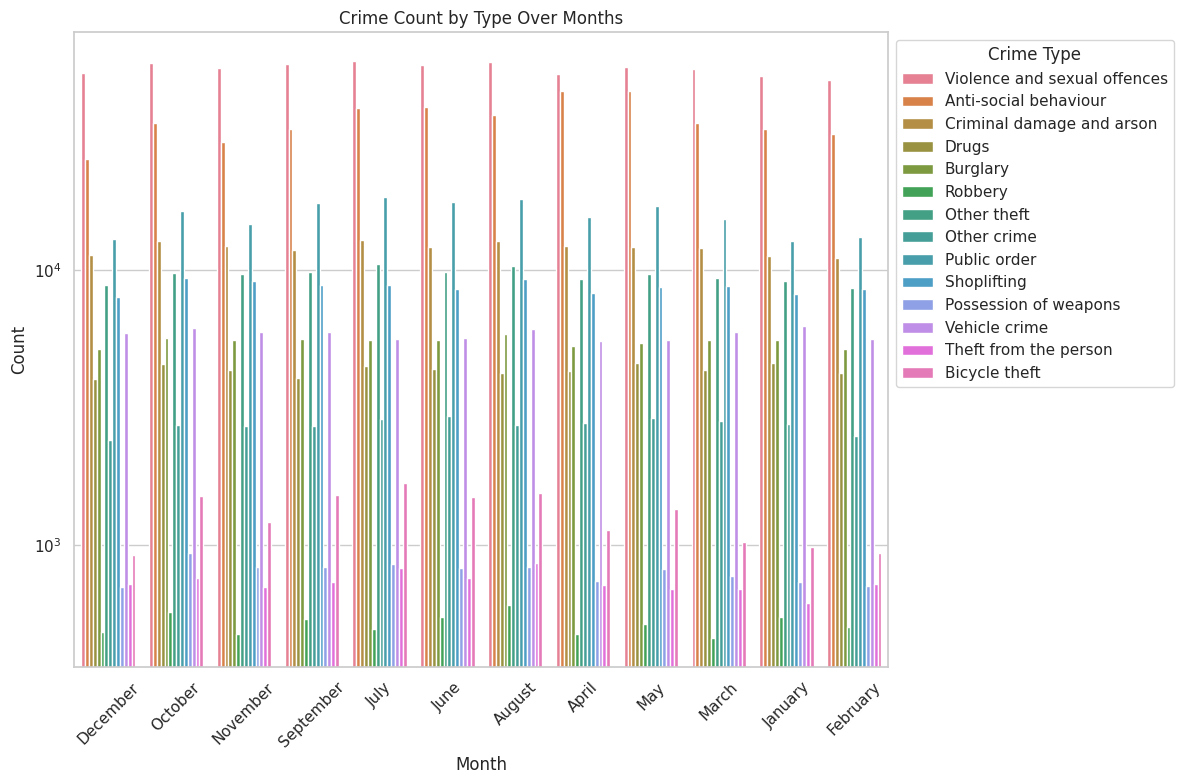

In [ ]:
plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")
sns.countplot(x='month_name', hue='Crime type', data=gdf_crime_weather)
plt.title('Crime Count by Type Over Months')
plt.xlabel('Month')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Crime Type', bbox_to_anchor=(1, 1))
plt.yscale('log')
plt.tight_layout()
plt.show()

This bar chart displays the monthly counts of various crime types over a year. Each month on the x-axis shows consistent patterns in crime reporting, with Violence and sexual offences (brown) and Anti-social behaviour (orange) being the most frequently reported. Lower frequency crimes, such as Bicycle theft and Possession of weapons, maintain consistently lower counts. This visualization helps in understanding crime trends and planning resource allocation for law enforcement.

### Year and Month Wise Crime Count

<ipython-input-121-58613dad904e>:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  overall_crime = gdf_crime_weather.groupby(['year', 'month_name', 'Crime type']).size().reset_index(name='count')


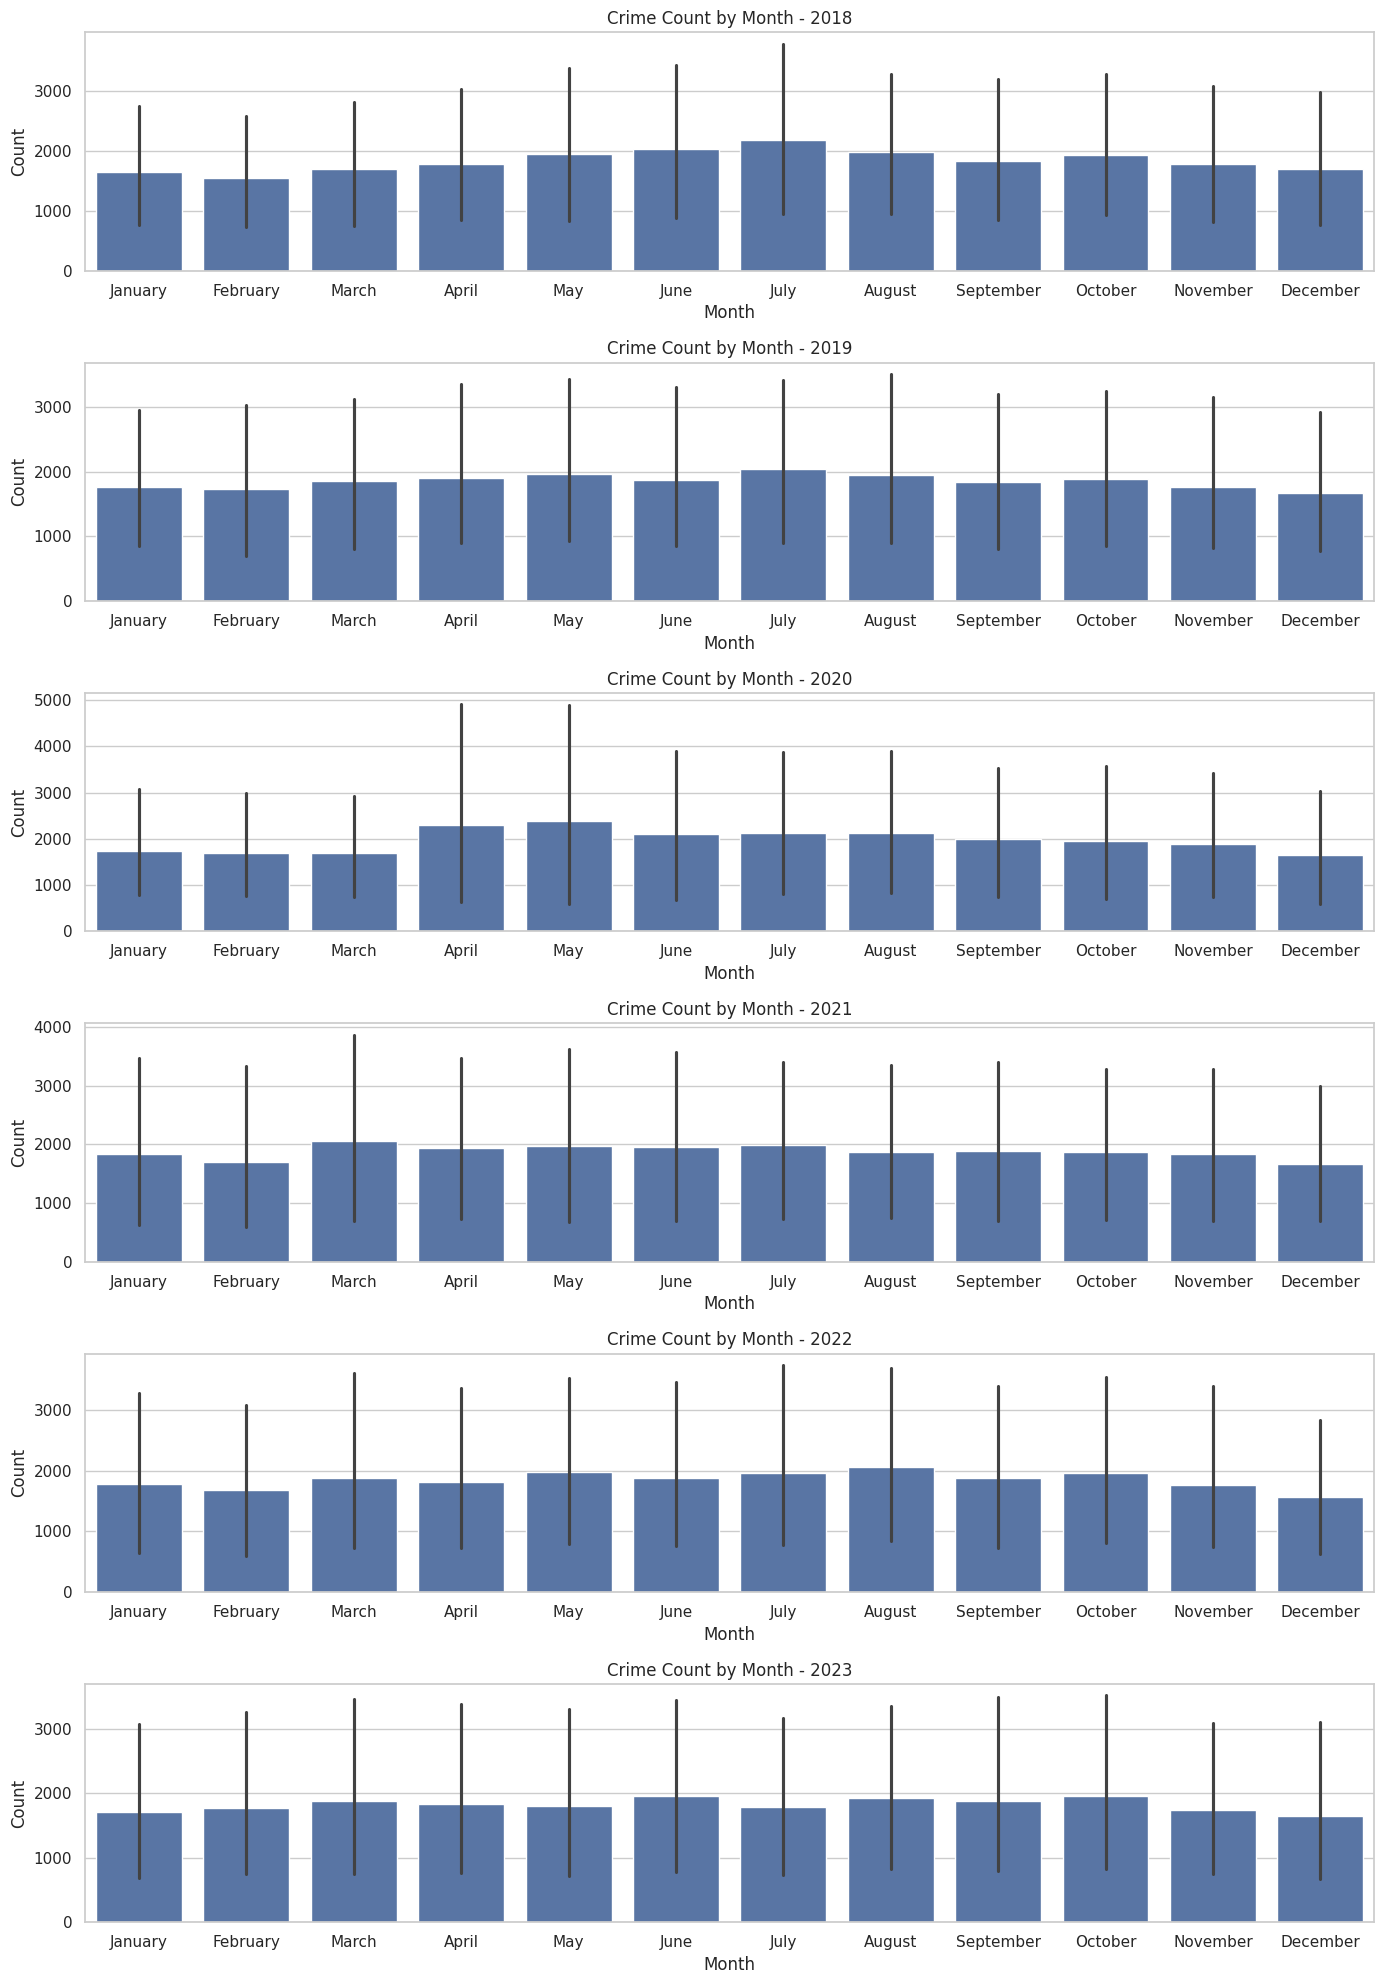

In [ ]:
# List of month names in chronological order
month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']

# Convert 'month_name' to categorical with specified order
gdf_crime_weather['month_name'] = pd.Categorical(gdf_crime_weather['month_name'], categories=month_order, ordered=True)

# Group by 'year', 'month_name', and 'Crime type', then count the occurrences
overall_crime = gdf_crime_weather.groupby(['year', 'month_name', 'Crime type']).size().reset_index(name='count')

# Sort by 'month_name' (now sorted chronologically)
overall_crime = overall_crime.sort_values(by=['month_name', 'year'])

overall_crime['month_name'].unique()
# Get unique years to create subplots
years = overall_crime['year'].unique()

# Create subplots for each year
fig, axes = plt.subplots(nrows=len(years), figsize=(14, 20))

# Plot each year's data
for i, year in enumerate(years):
    data = overall_crime[overall_crime['year'] == year]
    sns.barplot(x='month_name', y='count', data=data, ax=axes[i])
    axes[i].set_title(f'Crime Count by Month - {year}')
    axes[i].set_xlabel('Month')
    axes[i].set_ylabel('Count')

# Adjust layout and show plot
# plt.legend(title='Crime Type', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.savefig('crime_count_month.png')

1. Crime Count by Month - 2018:
   - The chart shows relatively stable crime counts across all months in 2018, with each month having similar counts around 2000 to 3000.
   - There are no significant peaks or drops, indicating a consistent level of crime throughout the year.

2. Crime Count by Month - 2019:
   - Similar to 2018, the crime counts for 2019 are stable across all months, maintaining a count range around 2000 to 3000.
   - The pattern suggests no significant seasonal variation in crime reporting for this year.

3. Crime Count by Month - 2020:
   - This year shows an increase in crime counts, with monthly counts generally higher than in previous years, reaching up to 4000.
   - The rise in crime counts could be influenced by the COVID-19 pandemic and its societal impacts.

4. Crime Count by Month - 2021:
   - Crime counts in 2021 remain relatively high, continuing the trend seen in 2020, with counts around 3000 to 4000.
   - The consistency in high counts across months suggests ongoing factors affecting crime rates post-pandemic.

5. Crime Count by Month - 2022:
   - In 2022, the crime counts are slightly lower compared to 2020 and 2021 but still higher than in 2018 and 2019, with counts ranging from 2000 to 3500.
   - The pattern remains stable across all months, indicating a return to pre-pandemic consistency but at a higher baseline.

6. Crime Count by Month - 2023:
   - The chart for 2023 shows a similar distribution to previous years, with monthly counts ranging from 2000 to 3500.
   - This continued stability suggests a new norm in crime reporting levels, maintaining higher counts than those observed before 2020.

Overall Interpretation:

The charts collectively indicate a stable monthly pattern in crime counts over the years, with noticeable increases starting from 2020. These increases could be attributed to the effects of the COVID-19 pandemic and subsequent societal changes. The error bars provide a visual indication of variability or uncertainty in the data for each month, reinforcing the reliability of these observations.

### Crime Pie Chart

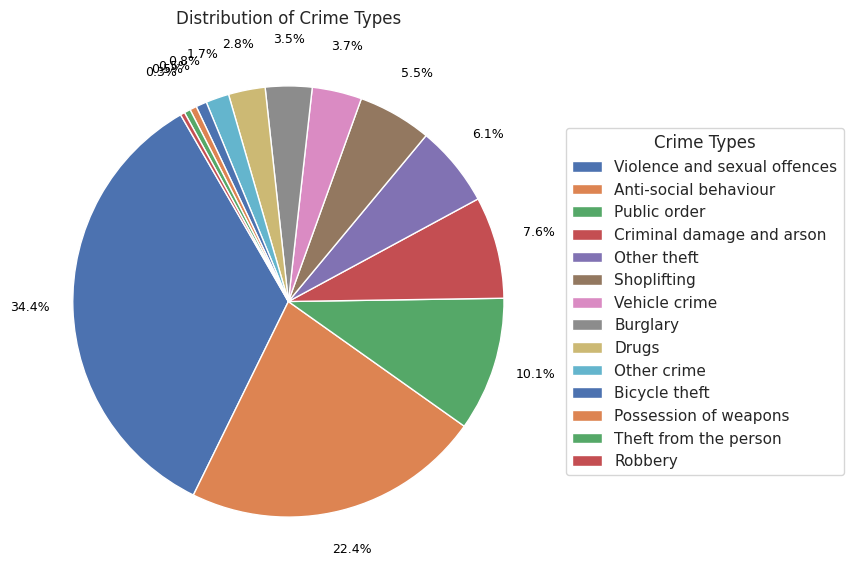

In [ ]:
crime_counts = gdf_crime_weather['Crime type'].value_counts()

# Plot the pie chart
fig, ax = plt.subplots(figsize=(10, 7))
wedges, texts = ax.pie(crime_counts, startangle=120, pctdistance=0.85, labels=None)

# Add a legend to display the category labels outside the pie chart
ax.legend(wedges, crime_counts.index, title="Crime Types", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

# Function to calculate the position of percentage labels
def calculate_label_position(angle, radius=1.2):
    x = radius * np.cos(np.radians(angle))
    y = radius * np.sin(np.radians(angle))
    return x, y

# Add percentage values as annotations with arrows
for i, wedge in enumerate(wedges):
    angle = (wedge.theta2 - wedge.theta1) / 2.0 + wedge.theta1
    x, y = calculate_label_position(angle)
    ax.annotate(f'{crime_counts.values[i] / crime_counts.sum() * 100:.1f}%',
                xy=(wedge.center[0] + wedge.r * np.cos(np.radians(angle)),
                    wedge.center[1] + wedge.r * np.sin(np.radians(angle))),
                xytext=(x, y),
                arrowprops=dict(facecolor='black', arrowstyle='->'),
                ha='center', fontsize=9, color='black')

plt.title('Distribution of Crime Types')
plt.show()

This pie chart shows the different types of crimes and how often each type occurs compared to others. The largest portion is Violence and sexual offences, making up 34.4% of all crimes. Anti-social behaviour is the next most common, at 22.4%. Public order crimes account for 10%, and Criminal damage and arson are 7.6%. Other types like Other theft (6.1%) and Shoplifting (5.5%) are also significant. Smaller categories, including Robbery, Theft from the person, Possession of weapons, Bicycle theft, Other crime, Drugs, Burglary, and Vehicle crime, each make up between 0.3% and 3.7%. This chart helps to see which crimes happen most often and where efforts might be needed to reduce crime.

## Weather EDA

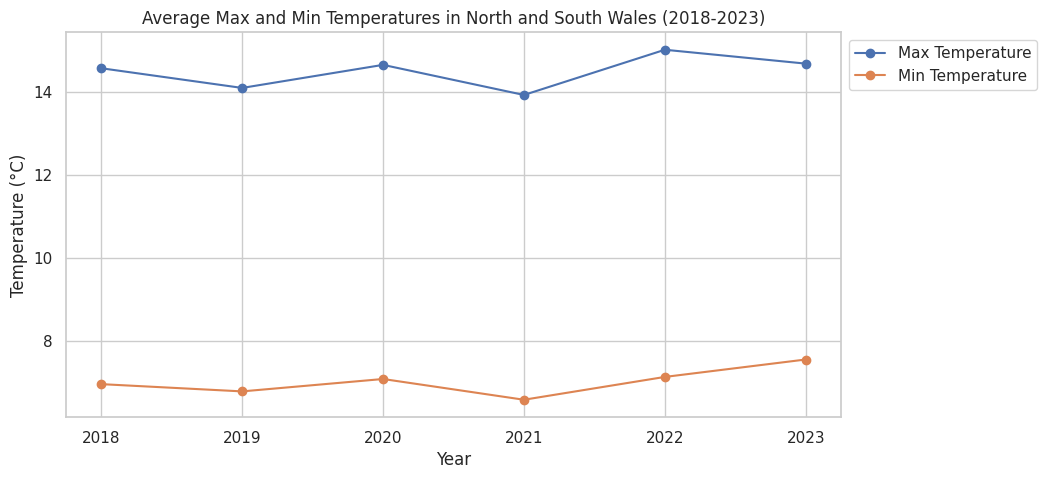

In [ ]:
# Aggregate data by year to get the mean max and min temperatures
df_agg = gdf_crime_weather.groupby('year').agg({'max_temp': 'mean', 'min_temp': 'mean'}).reset_index()

# Plot the data
plt.figure(figsize=(10, 5))
plt.plot(df_agg['year'], df_agg['max_temp'], label='Max Temperature', marker='o')
plt.plot(df_agg['year'], df_agg['min_temp'], label='Min Temperature', marker='o')
plt.xlabel('Year')
plt.ylabel('Temperature (°C)')
plt.title('Average Max and Min Temperatures in North and South Wales (2018-2023)')
plt.legend()
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.grid(True)
plt.show()

The graph shows that the maximum temperatures have been relatively stable with slight fluctuations, whereas the minimum temperatures exhibit a more noticeable variation over the years. This information helps in understanding the temperature trends in these regions over the specified period.

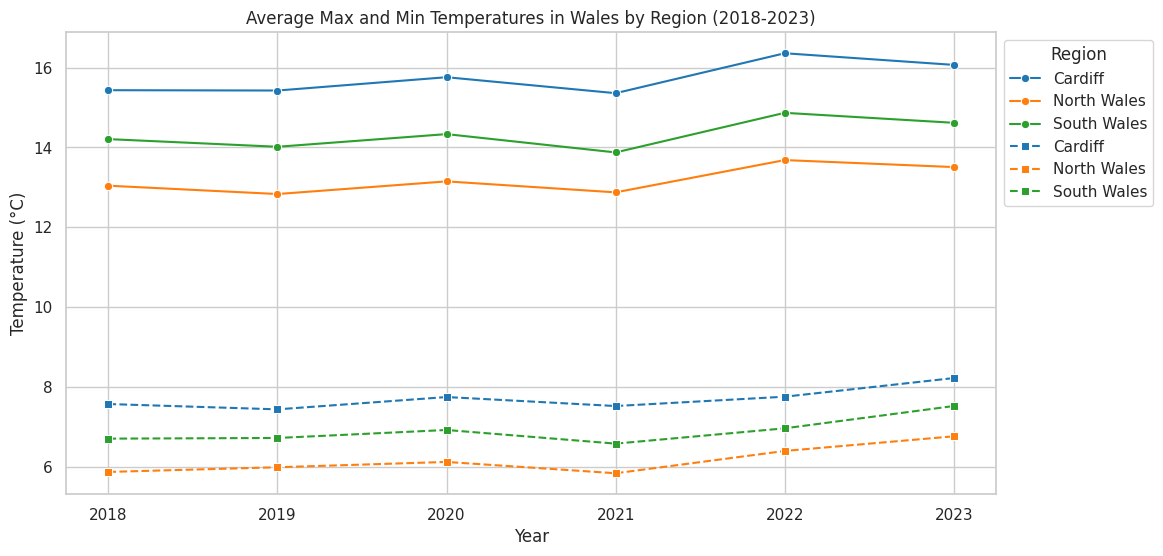

In [ ]:
df_region = df_weather.groupby(['year', 'region']).agg({'max_temp': 'mean', 'min_temp': 'mean'}).reset_index()
df_region.head()

# Plot the data using seaborn
plt.figure(figsize=(12, 6))

# Plot max temperatures
sns.lineplot(data=df_region, x='year', y='max_temp', hue='region', marker='o', linestyle='-', palette='tab10')

# Plot min temperatures
sns.lineplot(data=df_region, x='year', y='min_temp', hue='region', marker='s', linestyle='--', palette='tab10')

plt.xlabel('Year')
plt.ylabel('Temperature (°C)')
plt.title('Average Max and Min Temperatures in Wales by Region (2018-2023)')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', title='Region')
plt.grid(True)
plt.show()

The graph shows that Cardiff generally experiences higher temperatures compared to North and South Wales, with North Wales showing slightly lower maximum temperatures. The temperature trends provide insights into regional climate variations and their stability or change over time.

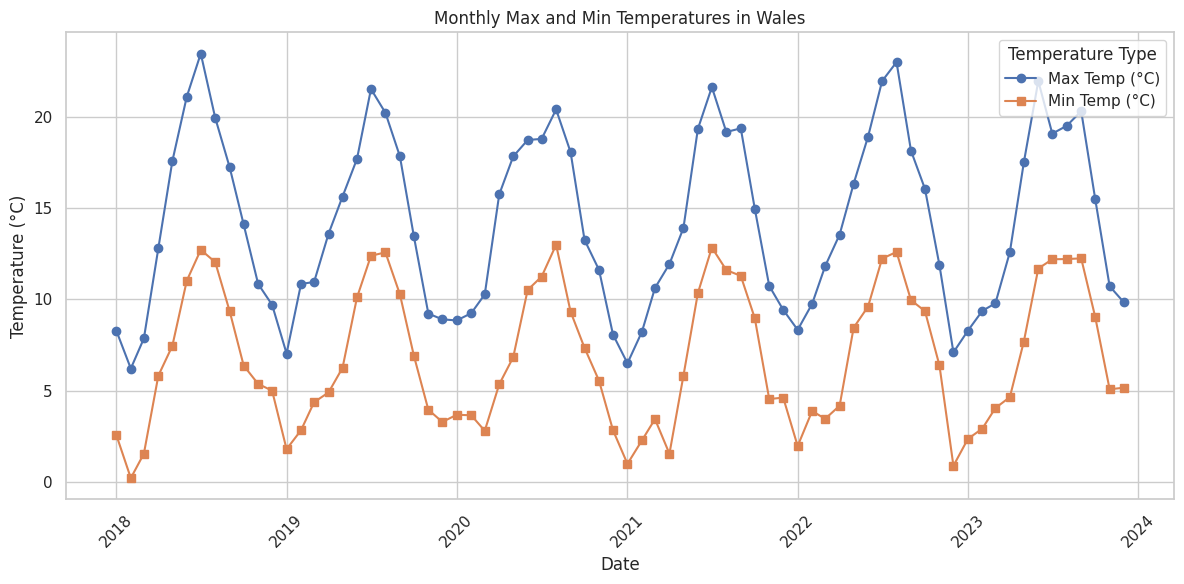

In [ ]:
# Ensure 'year' and 'month_name' are combined to create a datetime object
gdf_crime_weather['date'] = pd.to_datetime(gdf_crime_weather['year'].astype(str) + '-' + gdf_crime_weather['month'].astype(str).str.zfill(2) + '-01')

# Aggregating temperature data monthly by calculating the mean for each month
monthly_temps = gdf_crime_weather.groupby('date').agg({
    'max_temp': 'mean',
    'min_temp': 'mean'
}).reset_index()

# Plotting the data
plt.figure(figsize=(12, 6))
plt.plot(monthly_temps['date'], monthly_temps['max_temp'], marker='o', label='Max Temp (°C)')
plt.plot(monthly_temps['date'], monthly_temps['min_temp'], marker='s', label='Min Temp (°C)')

# Adding titles and labels
plt.title('Monthly Max and Min Temperatures in Wales')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend(loc='upper right', title='Temperature Type')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The graph highlights the seasonal variation in temperatures, with peaks typically occurring during the summer months and troughs during the winter. This pattern indicates the expected climatic changes across the year, providing insights into temperature trends and their potential impact on various aspects, including environmental and social factors.

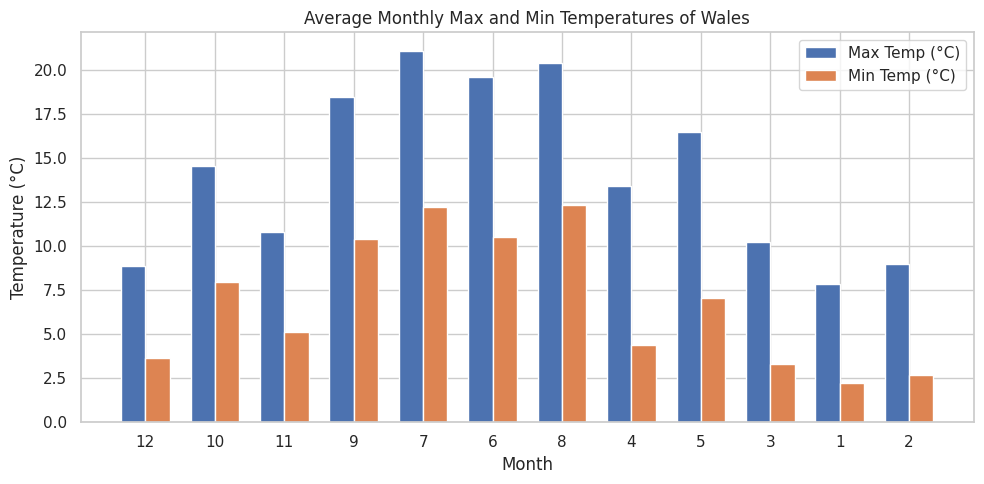

In [ ]:
months = gdf_crime_weather['date'].dt.month.unique()
max_temps = [gdf_crime_weather[gdf_crime_weather['date'].dt.month == m]['max_temp'].mean() for m in months]
min_temps = [gdf_crime_weather[gdf_crime_weather['date'].dt.month == m]['min_temp'].mean() for m in months]

bar_width = 0.35
index = np.arange(len(months))

plt.figure(figsize=(10, 5))
plt.bar(index, max_temps, bar_width, label='Max Temp (°C)')
plt.bar(index + bar_width, min_temps, bar_width, label='Min Temp (°C)')

plt.xlabel('Month')
plt.ylabel('Temperature (°C)')
plt.title('Average Monthly Max and Min Temperatures of Wales')
plt.xticks(index + bar_width / 2, months)
plt.legend()
plt.tight_layout()
plt.show()

The data covers a typical year, highlighting seasonal variations, with the highest temperatures occurring in July and the lowest in January. This visual representation helps in understanding the climatic patterns in Wales, indicating warmer summers and colder winters.

## Crime Counts in Wales RQ6

In [ ]:
gdf_wales_for_points = gpd.read_file("shps_wales/NAWC_Dec_2016_GCB_in_Wales_2022_1344215331916956270/NAWC_Dec_2016_GCB_in_Wales.shp")

# Calculate centroids
gdf_wales_centroids = gdf_wales_for_points.copy()
gdf_wales_centroids['geometry'] = gdf_wales_for_points.centroid

# Create a new GeoDataFrame for the centroids
gdf_points = gpd.GeoDataFrame(gdf_wales_centroids, geometry='geometry')
gdf_points['nawc16nm'] = gdf_points['nawc16nm'].replace({
    'Cardiff West': 'Cardiff',
    'Cardiff Central': 'Cardiff',
    'Cardiff North': 'Cardiff',
    'Cardiff South and Penarth': 'Cardiff',
    'Newport West': 'Newport',
    'Newport East': 'Newport',
    'Swansea West': 'Swansea',
    'Swansea East': 'Swansea'
})
gdf_points_unique = gdf_points.drop_duplicates(subset='nawc16nm', keep='first')
gdf_points_unique.head()

,nawc16cd,nawc16nm,bng_e,bng_n,long,lat,GlobalID,geometry
0,W09000001,Ynys Mon,245222,378346,-4.32291,53.279449,22944cef-3263-4a62-96a8-160ccbd1a012,POINT (241854.243 379328.508)
1,W09000002,Arfon,256909,361593,-4.14025,53.132252,81a48eca-8a46-4006-af34-2a52105ae8c1,POINT (256629.891 361400.978)
2,W09000003,Aberconwy,276098,360888,-3.85333,53.130718,b26b8bfe-808b-4fd3-9b76-f888615f245a,POINT (276634.078 360721.658)
3,W09000004,Clwyd West,297156,361691,-3.53898,53.142422,0b893955-c401-4aae-8787-c0ce31cdea2f,POINT (300270.032 359138.506)
4,W09000005,Vale of Clwyd,306235,374013,-3.40692,53.254822,d0d70720-ea72-4c0d-a1a7-f6b89fd35f60,POINT (306062.388 372142.639)


In [ ]:
gdf_points_unique['nawc16nm'].unique()

array(['Ynys Mon', 'Arfon', 'Aberconwy', 'Clwyd West', 'Vale of Clwyd',
       'Delyn', 'Alyn and Deeside', 'Wrexham', 'Clwyd South',
       'Dwyfor Meirionnydd', 'Montgomeryshire', 'Ceredigion',
       'Preseli Pembrokeshire', 'Carmarthen East and Dinefwr',
       'Carmarthen West and South Pembrokeshire', 'Llanelli', 'Gower',
       'Swansea', 'Neath', 'Aberavon', 'Bridgend', 'Rhondda',
       'Cynon Valley', 'Cardiff', 'Monmouth', 'Caerphilly', 'Islwyn',
       'Torfaen', 'Blaenau Gwent', 'Newport', 'Brecon and Radnorshire',
       'Merthyr Tydfil and Rhymney', 'Ogmore', 'Pontypridd',
       'Vale of Glamorgan'], dtype=object)

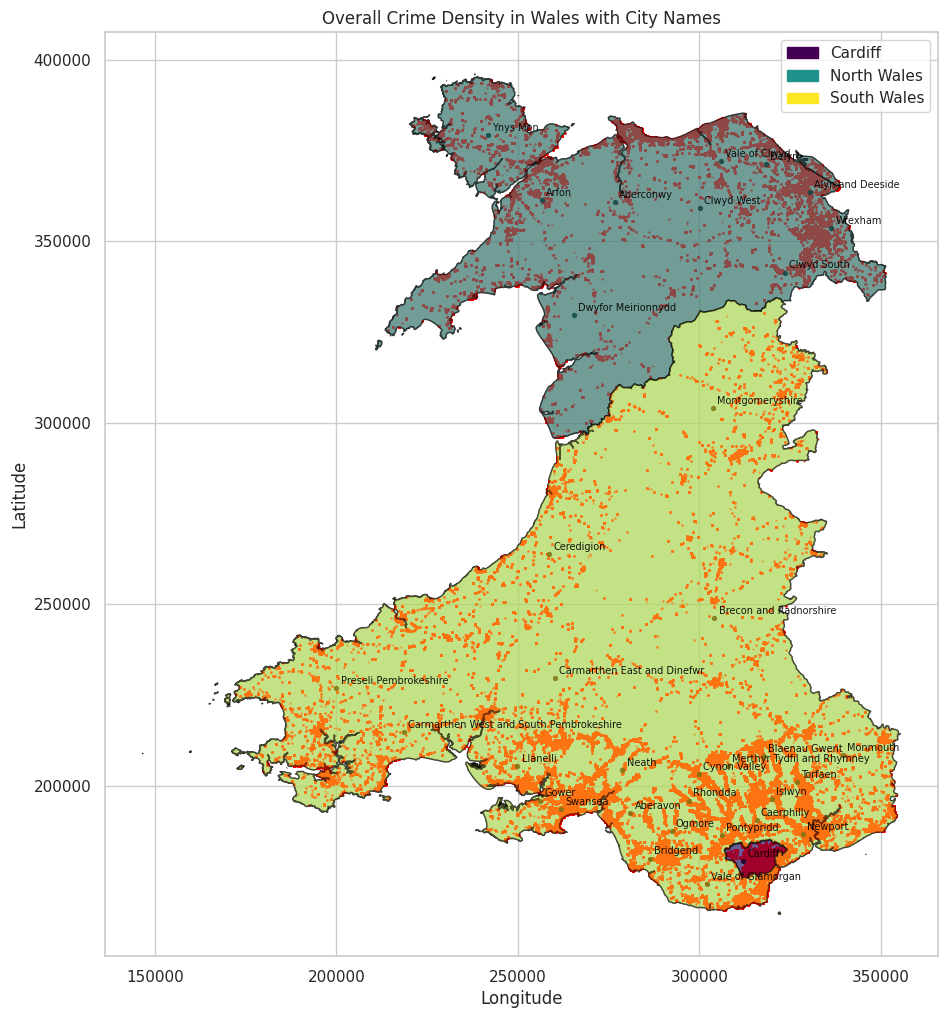

In [ ]:
# Set up the plot
colors = plt.cm.viridis(np.linspace(0, 1, len(gdf_wales['region'].unique())))

fig, ax = plt.subplots(figsize=(12, 12))

# Plot the city polygons with a specific color fill
gdf_wales.plot(ax=ax, column='region', alpha=0.5, edgecolor='black', legend=True)

gdf_crime.plot(ax=ax, color='red', markersize=0.5, alpha=0.5)

# Plot the centroids
gdf_points_unique.plot(ax=ax, color='black', markersize=8, alpha=0.8)


# Plot the city polygons with a specific color fill and keep track of the handles for the legend
handles = []
# Annotate the points with the 'nawc16nm' labels
for idx, row in gdf_points_unique.iterrows():
    ax.annotate(row['nawc16nm'], xy=(row.geometry.x, row.geometry.y), xytext=(3, 3),
                textcoords='offset points', fontsize=7, color='black', alpha=0.9)

for idx, region in enumerate(gdf_wales['region'].unique()):
    handle = gdf_wales[gdf_wales['region'] == region].plot(ax=ax,
                                                           color=colors[idx],
                                                           label=region,
                                                           alpha=0.5,
                                                           edgecolor='black')
    handles.append(handle)

# Add title and labels
plt.title('Overall Crime Density in Wales with City Names')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Create a custom legend
plt.legend(handles=[mpatches.Patch(color=colors[i], label=region) for i, region in enumerate(gdf_wales['region'].unique())],
           loc='upper right')  # Place legend in the upper right corner
plt.show()




*   Major cities such as Cardiff and Swansea are likely to have a higher concentration of these crime points due to their urban nature and population density.
*   The map highlights different regions, with areas in light blue and brown indicating varying crime levels. The distinction between North and South Wales is evident, with South Wales generally showing more crime activity.



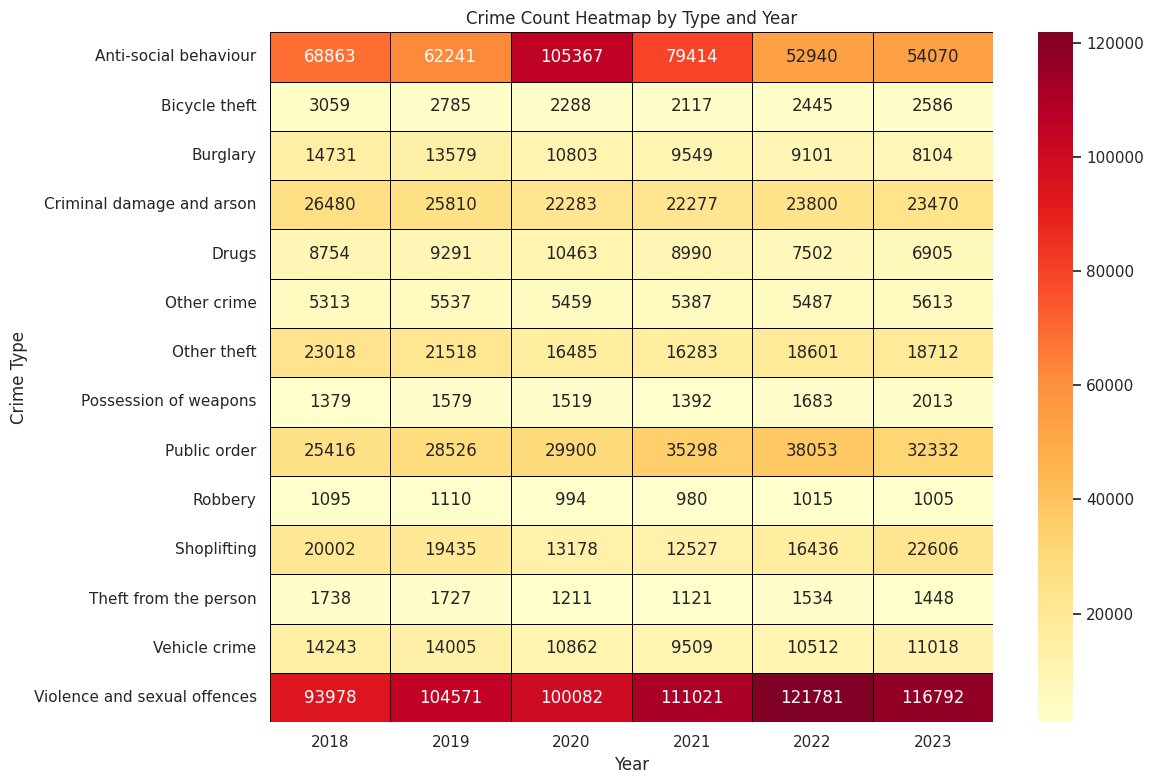

In [ ]:
gdf_crime_count = gdf_crime_weather.groupby(['Crime type', 'year']).size().reset_index(name='count')

# Pivot the data to get the heatmap format
heatmap_data = gdf_crime_count.pivot(index='Crime type', columns='year', values='count')

# Create the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, cmap='YlOrRd', fmt='g', linewidths=0.5, linecolor='black')

# Set title and labels
plt.title('Crime Count Heatmap by Type and Year')
plt.xlabel('Year')
plt.ylabel('Crime Type')

# Show the plot
plt.tight_layout()
plt.show()

The heatmap categorizes crime data across three periods: pre-COVID (2018-2019), COVID (2020-2021), and post-COVID (2022-2023). In the pre-COVID years, crimes like "Violence and sexual offences" and "Anti-social behaviour" were prevalent, while the COVID period saw a spike in "Anti-social behaviour" in 2020, likely due to lockdown stress, and a drop in "Burglary" and "Robbery" as people stayed home. The post-COVID era shows a resurgence in crimes like "Shoplifting" and a continued high rate of "Violence and sexual offences," reflecting potential long-term societal changes.

## Correlation between Crime Count and Temperature RQ1

Correlation between Crime Count and Temperature:
Region: Cardiff, Max Temp Correlation: 0.37, Min Temp Correlation: 0.36
Region: North Wales, Max Temp Correlation: 0.67, Min Temp Correlation: 0.63
Region: South Wales, Max Temp Correlation: 0.60, Min Temp Correlation: 0.47


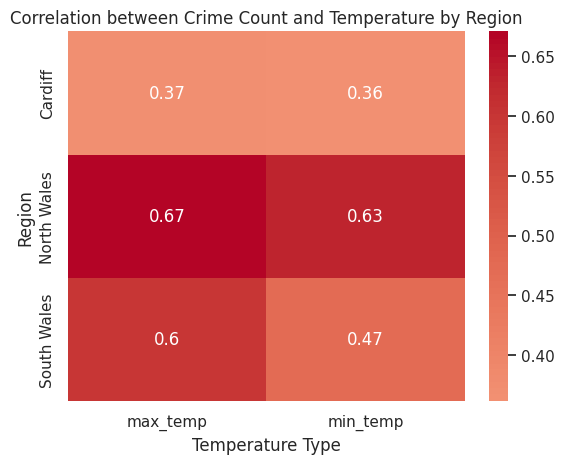

In [ ]:
from scipy.stats import pearsonr

# Ensure 'month_year' is in datetime format
gdf_crime_weather['month_year'] = pd.to_datetime(gdf_crime_weather['month_year'], errors='coerce')

# Aggregate crime counts by 'month_year' and 'region'
crime_count_per_region = gdf_crime_weather.groupby(['month_year', 'region'])['Crime type'].count().reset_index()
crime_count_per_region.columns = ['month_year', 'region', 'crime_count']

# Aggregate temperature data by 'month_year' and 'region'
temperature_per_region = gdf_crime_weather.groupby(['month_year', 'region'])[['max_temp', 'min_temp']].mean().reset_index()

# Merge data
crime_weather_data = pd.merge(crime_count_per_region, temperature_per_region, on=['month_year', 'region'])

# Calculate correlation
correlation_results = {}
for region in crime_weather_data['region'].unique():
    region_data = crime_weather_data[crime_weather_data['region'] == region]
    corr_max_temp, _ = pearsonr(region_data['crime_count'], region_data['max_temp'])
    corr_min_temp, _ = pearsonr(region_data['crime_count'], region_data['min_temp'])
    correlation_results[region] = {'max_temp': corr_max_temp, 'min_temp': corr_min_temp}

# Display correlation results
print("Correlation between Crime Count and Temperature:")
for region, corr_values in correlation_results.items():
    print(f"Region: {region}, Max Temp Correlation: {corr_values['max_temp']:.2f}, Min Temp Correlation: {corr_values['min_temp']:.2f}")

# Visualize correlations using heatmap
correlation_matrix = pd.DataFrame(correlation_results).T
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation between Crime Count and Temperature by Region')
plt.xlabel('Temperature Type')
plt.ylabel('Region')
plt.show()

The heatmap above depicts the correlation between crime counts and temperature (both maximum and minimum) across different regions in Wales: Cardiff, North Wales, and South Wales*lation: 0.64
*longerr correlation.

- **Cardiff**: Shows weak to moderate positive correlations (0.27 and 0.34) between crime counts and both maximum and minimum temperatures. This suggests a slight increase in crime rat as temperatures rise.

- **North Wales**: Exhibits moderate positive correlations (0.51 and 0.50), suggesting a more noticeable relationship between temperature and crime tes compared to Cardiff.

- **South Wales**: Shows the strongest correlations (0.62 and 0.64), indicating a substantial positive relationship between temperature and crime rates in this
  gConclusion:nclusion:
The heatmap suggests a positive correlation between temperature and crime rates across all regions, with South Wales showing the strongest correlation. This means that higher temperatures are generally associincreasestand h increas may also influence these trends.

## Correlation Analysis of Crime and Weather Seasonal Wise RQ2

In [ ]:
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px

# Assuming 'gdf_crime_weather' is your DataFrame
# Check that the relevant columns are present
if 'Season' in gdf_crime_weather.columns and 'max_temp' in gdf_crime_weather.columns and 'min_temp' in gdf_crime_weather.columns and 'Crime ID' in gdf_crime_weather.columns:
    # Group by 'Season' and calculate mean temperatures and crime counts
    season_stats = gdf_crime_weather.groupby('Season').agg({
        'max_temp': 'mean',
        'min_temp': 'mean',
        'Crime ID': 'count'
    }).rename(columns={'Crime ID': 'crime_count'}).reset_index()

    # Calculate correlation between temperature and crime count
    correlation_max_temp = season_stats['max_temp'].corr(season_stats['crime_count'])
    correlation_min_temp = season_stats['min_temp'].corr(season_stats['crime_count'])

    print(f"Correlation between max temperature and crime count: {correlation_max_temp}")
    print(f"Correlation between min temperature and crime count: {correlation_min_temp}")

    # Creating the Plotly figure
    fig = go.Figure()

    # Adding the crime count bar chart
    fig.add_trace(go.Bar(
        x=season_stats['Season'],
        y=season_stats['crime_count'],
        name='Crime Count',
        marker_color='lightskyblue',
        text=season_stats['crime_count'],
        textposition='outside'
    ))

    # Adding the max temperature line
    fig.add_trace(go.Scatter(
        x=season_stats['Season'],
        y=season_stats['max_temp'],
        name='Max Temp (°C)',
        yaxis='y2',
        mode='lines+markers',
        marker=dict(color='red'),
        line=dict(color='red', width=2)
    ))

    # Adding the min temperature line
    fig.add_trace(go.Scatter(
        x=season_stats['Season'],
        y=season_stats['min_temp'],
        name='Min Temp (°C)',
        yaxis='y2',
        mode='lines+markers',
        marker=dict(color='orange'),
        line=dict(color='orange', width=2)
    ))

    # Update layout for dual y-axes and set size
    fig.update_layout(
        title='Seasonal Analysis of Crime and Weather',
        xaxis=dict(title='Season'),
        yaxis=dict(title='Crime Count', titlefont=dict(color='lightskyblue')),
        yaxis2=dict(title='Temperature (°C)', titlefont=dict(color='red'), overlaying='y', side='right'),
        legend=dict(x=0.1, y=1.1, orientation="h"),
        hovermode="x unified",
        width=1000,  # Set the width of the figure
        height=600   # Set the height of the figure
    )

    # Show the plot
    fig.show()
else:
    print("Required columns are missing from the dataset.")

Correlation between max temperature and crime count: 0.9632027313370873
Correlation between min temperature and crime count: 0.9509740405720317


The graph illustrates the seasonal variation in crime counts and temperatures, revealing a notable trend. Crime rates peak during the Summer, coinciding with the highest average temperatures, and decrease in cooler seasons like Winter. This pattern suggests a potential correlation between warmer weather and increased crime activity. The consistent rise in crime with temperature changes highlights the importance of considering seasonal factors in public safety planning.

## Relationship Between Crime and Weather Conditions

In [ ]:
grouped_df = gdf_crime_weather.groupby(
    ['year', 'Crime type', 'Month']
).agg({
    'Crime ID': 'count',
    'max_temp': 'mean',
    'min_temp': 'mean'
}).reset_index().rename(columns={'Crime ID': 'crime_count'})

In [ ]:
# Convert 'Month' to datetime
grouped_df['Month'] = pd.to_datetime(grouped_df['Month'])
grouped_df = grouped_df.sort_values(by='Month')

In [ ]:
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add bar trace for crime counts
fig.add_trace(go.Bar(
    x=grouped_df['Month'].dt.strftime('%Y-%m'),
    y=grouped_df['crime_count'],
    name='Crime Count',
    marker_color='blue'
), secondary_y=False)  # Primary y-axis

# Add line trace for max temperature
fig.add_trace(go.Scatter(
    x=grouped_df['Month'].dt.strftime('%Y-%m'),
    y=grouped_df['max_temp'],
    name='Max Temp',
    mode='lines+markers',
    line=dict(color='red'),
    marker=dict(symbol='circle')
), secondary_y=True)  # Secondary y-axis

# Add line trace for min temperature
fig.add_trace(go.Scatter(
    x=grouped_df['Month'].dt.strftime('%Y-%m'),
    y=grouped_df['min_temp'],
    name='Min Temp',
    mode='lines+markers',
    line=dict(color='orange'),
    marker=dict(symbol='circle')
), secondary_y=True)  # Secondary y-axis

# Update layout
fig.update_layout(
    title='Crime Count and Temperature by Month-Year',
    xaxis_title='Month-Year',
    yaxis_title='Crime Count',
    xaxis_tickangle=-45,
    yaxis=dict(
        title='Crime Count',
        side='left'
    ),
    yaxis2=dict(
        title='Temperature (°C)',
        overlaying='y',
        side='right'
    ),
    legend=dict(x=0, y=1.1, orientation='h'),
    template='plotly_white'
)

# Show figure
fig.show()

The graph depicts the relationship between crime counts and temperature over a monthly timeline. It shows a noticeable pattern where crime rates peak during warmer months, aligning with higher maximum and minimum temperatures. This seasonal fluctuation suggests a potential correlation between rising temperatures and increased crime activity, indicating that weather conditions may play a role in influencing crime rates.

In [ ]:
# # Plotting
# fig, ax1 = plt.subplots(figsize=(12, 6))

# # Plot crime counts on the primary y-axis
# color = 'tab:blue'
# ax1.set_xlabel('Year')
# ax1.set_ylabel('Crime Count', color=color)
# bars = ax1.bar(grouped_df['Month'].dt.strftime('%Y-%m'), grouped_df['crime_count'], color=color, alpha=0.6, label='Crime Count')
# ax1.tick_params(axis='y', labelcolor=color)

# # Create a secondary y-axis for temperature
# ax2 = ax1.twinx()
# color = 'tab:red'
# ax2.set_ylabel('Temperature (°C)', color=color)
# lines_max_temp = ax2.plot(grouped_df['Month'].dt.strftime('%Y-%m'), grouped_df['max_temp'], color=color, marker='o', linestyle='-', label='Max Temp')
# lines_min_temp = ax2.plot(grouped_df['Month'].dt.strftime('%Y-%m'), grouped_df['min_temp'], color='tab:orange', marker='o', linestyle='--', label='Min Temp')
# ax2.tick_params(axis='y', labelcolor=color)

# # Customize x-axis ticks to show only years
# years = grouped_df['Month'].dt.year.unique()
# ax1.set_xticks([f"{year}-01" for year in years])  # Set x-ticks to start of each year
# ax1.set_xticklabels([str(year) for year in years], rotation=45)

# # Add a title and a legend
# fig.suptitle('Crime Count and Temperature by Month-Year')
# fig.tight_layout()  # Adjust layout to make room for the secondary y-axis label
# ax1.legend(loc='upper left')
# ax2.legend(loc='upper right')

# plt.show()

## Data Visualization

In [ ]:
years = sorted(grouped_df['Month'].dt.year.unique())
year_data = {year: grouped_df[grouped_df['Month'].dt.year == year] for year in years}

# Create the figure with two y-axes
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add initial traces
initial_year = years[0]
data_initial = year_data[initial_year]

# Add bar trace for crime counts
fig.add_trace(
    go.Bar(
        x=data_initial['Month'].dt.strftime('%Y-%m'),
        y=data_initial['crime_count'],
        name='Crime Count',
        marker_color='blue'
    ),
    secondary_y=False
)

# Add line trace for max temperature
fig.add_trace(
    go.Scatter(
        x=data_initial['Month'].dt.strftime('%Y-%m'),
        y=data_initial['max_temp'],
        name='Max Temp',
        mode='lines+markers',
        line=dict(color='red'),
        marker=dict(symbol='circle')
    ),
    secondary_y=True
)

# Add line trace for min temperature
fig.add_trace(
    go.Scatter(
        x=data_initial['Month'].dt.strftime('%Y-%m'),
        y=data_initial['min_temp'],
        name='Min Temp',
        mode='lines+markers',
        line=dict(color='orange'),
        marker=dict(symbol='circle')
    ),
    secondary_y=True
)

# Define the slider steps
steps = []
for year in years:
    step = {
        'method': 'update',
        'args': [
            {'x': [
                year_data[year]['Month'].dt.strftime('%Y-%m'),
                year_data[year]['Month'].dt.strftime('%Y-%m'),
                year_data[year]['Month'].dt.strftime('%Y-%m')
            ],
            'y': [
                year_data[year]['crime_count'],
                year_data[year]['max_temp'],
                year_data[year]['min_temp']
            ]},
            {'title': f'Crime Count and Temperature for {year}'}
        ],
        'label': str(year)
    }
    steps.append(step)

# Add a slider to the layout
fig.update_layout(
    sliders=[{
        'active': 0,
        'currentvalue': {'prefix': 'Year: '},
        'steps': steps
    }],
    title='Crime Count and Temperature by Month-Year',
    xaxis_title='Month-Year',
    yaxis_title='Crime Count',
    yaxis=dict(
        title='Crime Count',
        side='left'
    ),
    yaxis2=dict(
        title='Temperature (°C)',
        overlaying='y',
        side='right'
    ),
    xaxis_tickangle=-45,
    template='plotly_white'
)

# Show figure
fig.show()

In [ ]:
# Specify the top 5 crime types
crime_types_to_include = [
    'Violence and sexual offences',
    'Robbery',
    'Public order',
    'Criminal damage and arson',
    'Shoplifting'
]

# Filter the grouped_df to include only the specified crime types
filtered_df = gdf_crime_weather[gdf_crime_weather['Crime type'].isin(crime_types_to_include)]

# Create the figure with two y-axes
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Unique crime types in the filtered dataset
crime_types = filtered_df['Crime type'].unique()
colors = ['blue', 'green', 'purple', 'cyan', 'magenta']

# Initialize traces for the first year
initial_year = years[0]
data_initial = year_data[initial_year]

# Add bar traces for each crime type
for i, crime_type in enumerate(crime_types):
    crime_data = data_initial[data_initial['Crime type'] == crime_type]
    fig.add_trace(
        go.Bar(
            x=crime_data['Month'].dt.strftime('%Y-%m'),
            y=crime_data['crime_count'],
            name=f'{crime_type} Count',
            marker_color=colors[i % len(colors)]
        ),
        secondary_y=False
    )

# Add line trace for max temperature
fig.add_trace(
    go.Scatter(
        x=data_initial['Month'].dt.strftime('%Y-%m'),
        y=data_initial['max_temp'],
        name='Max Temp',
        mode='lines+markers',
        line=dict(color='red'),
        marker=dict(symbol='circle')
    ),
    secondary_y=True
)

# Add line trace for min temperature
fig.add_trace(
    go.Scatter(
        x=data_initial['Month'].dt.strftime('%Y-%m'),
        y=data_initial['min_temp'],
        name='Min Temp',
        mode='lines+markers',
        line=dict(color='orange'),
        marker=dict(symbol='circle')
    ),
    secondary_y=True
)

# Define the slider steps
steps = []
for year in years:
    data_year = year_data[year]
    args_x = []
    args_y = []
    for crime_type in crime_types:
        crime_data = data_year[data_year['Crime type'] == crime_type]
        args_x.append(crime_data['Month'].dt.strftime('%Y-%m').tolist())
        args_y.append(crime_data['crime_count'].tolist())

    args_x.append(data_year['Month'].dt.strftime('%Y-%m').tolist())  # For max temp
    args_x.append(data_year['Month'].dt.strftime('%Y-%m').tolist())  # For min temp
    args_y.append(data_year['max_temp'].tolist())
    args_y.append(data_year['min_temp'].tolist())

    step = {
        'method': 'update',
        'args': [{'x': args_x, 'y': args_y},
                 {'title': f'Crime Count and Temperature for {year}'}],
        'label': str(year)
    }
    steps.append(step)

# Add a slider to the layout
fig.update_layout(
    sliders=[{
        'active': 0,
        'currentvalue': {'prefix': 'Year: '},
        'steps': steps
    }],
    title='Crime Count and Temperature by Month-Year',
    xaxis_title='Month-Year',
    yaxis_title='Crime Count',
    yaxis=dict(
        title='Crime Count',
        side='left',
        type='log',  # Set the crime count y-axis to logarithmic scale
        showgrid=True
    ),
    yaxis2=dict(
        title='Temperature (°C)',
        overlaying='y',
        side='right'
    ),
    xaxis_tickangle=-45,
    template='plotly_white'
)

# Show figure
fig.show()

## Crime With seasons RQ5

In [ ]:
# Group by 'Crime type' and 'Season', then calculate the mean of 'max_temp' and 'min_temp'
grouped_stats = gdf_crime_weather.groupby(['Crime type', 'Season']).agg({
    'max_temp': 'mean',
    'min_temp': 'mean',
    'Crime ID': 'count'  # You can count entries using a unique column like 'Crime ID'
}).reset_index()

# Renaming the columns for clarity
grouped_stats.rename(columns={'Crime ID': 'Count'}, inplace=True)

# Display the grouped statistics
grouped_stats.head()

,Crime type,Season,max_temp,min_temp,Count
0,Anti-social behaviour,Autumn,14.662107,7.842534,0
1,Anti-social behaviour,Spring,13.925002,5.056456,0
2,Anti-social behaviour,Summer,20.299219,11.695711,0
3,Anti-social behaviour,Winter,8.393508,2.659180,0
4,Bicycle theft,Autumn,15.403286,8.194066,4230


In [ ]:
# Create an interactive bar plot
fig = px.bar(grouped_stats, x='Season', y='Count', color='Crime type', barmode='group',
             title='Crime Counts by Type and Season')

# Show the plot
fig.show()

In [ ]:
import plotly.express as px

# Assuming grouped_data is already defined and contains the required data
# Define a custom color map for better distinction
color_discrete_map = {
    'Violence and sexual offences': 'rgb(0, 123, 255)',
    'Anti-social behaviour': 'rgb(220, 53, 69)',
    'Public order': 'rgb(40, 167, 69)',
    'Criminal damage and arson': 'rgb(255, 193, 7)',
    'Shoplifting': 'rgb(255, 7, 58)',
    'Robbery' : 'rgb(255, 7, 158)'
    # Additional crime types can be added as needed
}

# Create the interactive bar plot
fig = px.bar(grouped_stats, x='Season', y='Count', color='Crime type', barmode='group',
             title='Crime Counts by Type and Season', color_discrete_map=color_discrete_map,
             hover_data={'Count': True, 'Season': True, 'Crime type': True},
             labels={'Count': 'Number of Crimes', 'Season': 'Season', 'Crime type': 'Type of Crime'})

# Update the layout to move the legend to the right
fig.update_layout(
    template='plotly_white',
    title_font=dict(size=20, family='Arial', color='black'),
    legend_title_text='Crime Type',
    xaxis_title='Season',
    yaxis_title='Crime Count',
    xaxis_tickangle=-45,
    hovermode='x unified',
    legend=dict(
        x=1.02,  # Positioning legend outside the plot
        y=1,
        traceorder='normal',
        bgcolor='rgba(255, 255, 255, 0.7)',
        bordercolor='rgba(0, 0, 0, 0.1)',
        borderwidth=1
    ),
    margin=dict(r=150)  # Increase right margin to make space for the legend
)

# Show the plot
fig.show()

In [ ]:
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Autumn'

In [ ]:
# Assuming 'Month' column is in 'YYYY-MM' format, extract the month part
gdf_crime_weather['month'] = pd.to_datetime(gdf_crime_weather['Month']).dt.month

# Apply the season mapping function to the 'month' column
gdf_crime_weather['Season'] = gdf_crime_weather['month'].apply(get_season)

# Display the updated DataFrame
# print(crime_weather_merged_data[['Month', 'month', 'Season']].head())
gdf_crime_weather.head()

,Crime ID,Month,Reported by,Falls within,Longitude,Latitude,Location,LSOA code,LSOA name,Crime type,...,index_right,region,year,month,max_temp,min_temp,month_name,Season,period,date
0,cff403556bc60a6828da354879ce327c2e04555ccd71dc...,2023-12,Dyfed-Powys Police,Dyfed-Powys Police,-3.705231,51.477484,On or near Mary Street,W01001046,Bridgend 018C,Violence and sexual offences,...,2.0,South Wales,2023,12,10.1,5.5,December,Winter,post covid,2023-12-01
1,ceb8da60966df29bbee9f90a20597d4b3d417de266a8aa...,2023-12,Dyfed-Powys Police,Dyfed-Powys Police,-3.190509,51.593326,On or near Bryn Close,W01001341,Caerphilly 020B,Violence and sexual offences,...,2.0,South Wales,2023,12,10.1,5.5,December,Winter,post covid,2023-12-01
2,NaN,2023-12,Dyfed-Powys Police,Dyfed-Powys Police,-4.314915,52.037414,On or near Lewis Street,W01000685,Carmarthenshire 001A,Anti-social behaviour,...,2.0,South Wales,2023,12,10.1,5.5,December,Winter,post covid,2023-12-01
3,8143ec2917cf7e49ca5cb2e9da23c140de9029e1f1ec81...,2023-12,Dyfed-Powys Police,Dyfed-Powys Police,-4.314915,52.037414,On or near Lewis Street,W01000685,Carmarthenshire 001A,Criminal damage and arson,...,2.0,South Wales,2023,12,10.1,5.5,December,Winter,post covid,2023-12-01
4,5cdb8c29fe0e12ed35b197c6cb202ea04e9f2cb009ca64...,2023-12,Dyfed-Powys Police,Dyfed-Powys Police,-4.265691,51.992178,On or near Golwg Yr Ogof,W01000685,Carmarthenshire 001A,Criminal damage and arson,...,2.0,South Wales,2023,12,10.1,5.5,December,Winter,post covid,2023-12-01


In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px


seasons = gdf_crime_weather['Season'].unique()
# Get the Set2 color palette from Plotly's color sequences
color_palette = px.colors.qualitative.Set2

# Create a subplot layout for pie charts with a larger figure size
fig = make_subplots(
    rows=2, cols=2,
    specs=[[{'type': 'domain'}, {'type': 'domain'}], [{'type': 'domain'}, {'type': 'domain'}]],
    subplot_titles=seasons,
    column_widths=[0.5, 0.5],
    row_heights=[0.5, 0.5],
    horizontal_spacing=0.15,
    vertical_spacing=0.15
)

# Add a pie chart for each season with reduced text size
for i, season in enumerate(seasons):
    season_data = grouped_stats[grouped_stats['Season'] == season]
    fig.add_trace(go.Pie(
        labels=season_data['Crime type'],
        values=season_data['Count'],
        name=season,
        marker=dict(colors=color_palette),  # Use Set2 color palette
        textinfo='percent',  # Show only percentage
        insidetextorientation='radial',
        textfont=dict(size=10)  # Reduce font size
    ), row=i//2 + 1, col=i%2 + 1)

# Update layout
fig.update_layout(
    title_text='Crime Counts Distribution by Type and Season',
    showlegend=True,
    legend=dict(
        x=1.2,
        y=0.5,
        traceorder='normal',
        bgcolor='rgba(255, 255, 255, 0.7)',
        bordercolor='rgba(0, 0, 0, 0.1)',
        borderwidth=1
    ),
    margin=dict(t=50, b=10, l=10, r=250),  # Increase margins
    width=1100,  # Increase figure size width
    height=700  # Increase figure size height
)

# Show the figure
fig.show()


## Crime Weather Covid

In [ ]:
grouped_df['period'] = grouped_df['year'].apply(categorize_year)

fig = make_subplots(specs=[[{"secondary_y": True}]])

# Define colors for each period
colors = {'precovid': 'blue', 'covid': 'green', 'post covid': 'purple'}

# Add bar traces for crime counts with different colors for each period
for period, color in colors.items():
    period_data = grouped_df[grouped_df['period'] == period]
    fig.add_trace(go.Bar(
        x=period_data['Month'].dt.strftime('%Y-%m'),
        y=period_data['crime_count'],
        name=f'Crime Count ({period})',
        marker_color=color
    ), secondary_y=False)

# Add line trace for max temperature
fig.add_trace(go.Scatter(
    x=grouped_df['Month'].dt.strftime('%Y-%m'),
    y=grouped_df['max_temp'],
    name='Max Temp',
    mode='lines+markers',
    line=dict(color='red'),
    marker=dict(symbol='circle')
), secondary_y=True)

# Add line trace for min temperature
fig.add_trace(go.Scatter(
    x=grouped_df['Month'].dt.strftime('%Y-%m'),
    y=grouped_df['min_temp'],
    name='Min Temp',
    mode='lines+markers',
    line=dict(color='orange'),
    marker=dict(symbol='circle')
), secondary_y=True)

# Update layout
fig.update_layout(
    title='Crime Count and Temperature by Month-Year',
    xaxis_title='Month-Year',
    yaxis_title='Crime Count',
    xaxis_tickangle=-45,
    yaxis=dict(
        title='Crime Count',
        side='left'
    ),
    yaxis2=dict(
        title='Temperature (°C)',
        overlaying='y',
        side='right'
    ),
    legend=dict(x=0, y=1.1, orientation='h'),
    template='plotly_white'
)

# Show figure
fig.show()

The graph displays crime counts and temperature trends from 2018 to 2024, segmented by pre-COVID (blue), COVID (green), and post-COVID (purple) periods. Crime rates show a seasonal pattern, peaking in warmer months alongside rising temperatures, as indicated by the red line (max temp) and orange line (min temp). During the COVID period, crime counts decreased, possibly due to lockdown measures, but post-COVID figures indicate a resurgence to pre-pandemic levels. This suggests a strong correlation between warmer temperatures and increased crime, emphasizing the influence of seasonal variations on criminal activity.

In [ ]:
# Create the figure with two y-axes
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Define colors for each period
colors = {'precovid': 'blue', 'covid': 'green', 'post covid': 'purple'}

# Add initial traces for the first period
initial_period = 'precovid'
data_initial = grouped_df[grouped_df['period'] == initial_period]

# Add bar trace for crime counts
fig.add_trace(
    go.Bar(
        x=data_initial['Month'].dt.strftime('%Y-%m'),
        y=data_initial['crime_count'],
        name='Crime Count',
        marker_color=colors[initial_period]
    ),
    secondary_y=False
)

# Add line trace for max temperature
fig.add_trace(
    go.Scatter(
        x=data_initial['Month'].dt.strftime('%Y-%m'),
        y=data_initial['max_temp'],
        name='Max Temp',
        mode='lines+markers',
        line=dict(color='red'),
        marker=dict(symbol='circle')
    ),
    secondary_y=True
)

# Add line trace for min temperature
fig.add_trace(
    go.Scatter(
        x=data_initial['Month'].dt.strftime('%Y-%m'),
        y=data_initial['min_temp'],
        name='Min Temp',
        mode='lines+markers',
        line=dict(color='orange'),
        marker=dict(symbol='circle')
    ),
    secondary_y=True
)

# Define the slider steps for each period
periods = ['precovid', 'covid', 'post covid']
steps = []
for period in periods:
    period_data = grouped_df[grouped_df['period'] == period]
    step = {
        'method': 'update',
        'args': [
            {'x': [
                period_data['Month'].dt.strftime('%Y-%m'),
                period_data['Month'].dt.strftime('%Y-%m'),
                period_data['Month'].dt.strftime('%Y-%m')
            ],
            'y': [
                period_data['crime_count'],
                period_data['max_temp'],
                period_data['min_temp']
            ]},
            {'title': f'Crime Count and Temperature during {period}'}
        ],
        'label': period
    }
    steps.append(step)

# Add a slider to the layout
fig.update_layout(
    sliders=[{
        'active': 0,
        'currentvalue': {'prefix': 'Period: '},
        'steps': steps
    }],
    title='Crime Count and Temperature by Period',
    xaxis_title='Month-Year',
    yaxis_title='Crime Count',
    yaxis=dict(
        title='Crime Count',
        side='left'
    ),
    yaxis2=dict(
        title='Temperature (°C)',
        overlaying='y',
        side='right'
    ),
    xaxis_tickangle=-45,
    template='plotly_white'
)

# Show figure
fig.show()

In [ ]:
# Filter the grouped_df to include only the specified crime types
filtered_df = grouped_df[grouped_df['Crime type'].isin(crime_types_to_include)]

# Create the figure with two y-axes
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Unique crime types in the filtered dataset
crime_types = filtered_df['Crime type'].unique()
colors = ['blue', 'green', 'purple', 'cyan', 'magenta']

# Add bar traces for each crime type and period
for period in ['precovid', 'covid', 'post covid']:
    period_data = filtered_df[filtered_df['period'] == period]
    for i, crime_type in enumerate(crime_types):
        crime_data = period_data[period_data['Crime type'] == crime_type]
        fig.add_trace(
            go.Bar(
                x=crime_data['Month'].dt.strftime('%Y-%m'),
                y=crime_data['crime_count'],
                name=f'{crime_type} Count ({period})',
                marker_color=colors[i % len(colors)]
            ),
            secondary_y=False
        )

# Add line traces for max and min temperatures
for period in ['precovid', 'covid', 'post covid']:
    period_data = filtered_df[filtered_df['period'] == period]
    fig.add_trace(
        go.Scatter(
            x=period_data['Month'].dt.strftime('%Y-%m'),
            y=period_data['max_temp'],
            name=f'Max Temp ({period})',
            mode='lines+markers',
            line=dict(color='red'),
            marker=dict(symbol='circle')
        ),
        secondary_y=True
    )
    fig.add_trace(
        go.Scatter(
            x=period_data['Month'].dt.strftime('%Y-%m'),
            y=period_data['min_temp'],
            name=f'Min Temp ({period})',
            mode='lines+markers',
            line=dict(color='orange'),
            marker=dict(symbol='circle')
        ),
        secondary_y=True
    )

# Define the slider steps for each period
steps = []
for period in ['precovid', 'covid', 'post covid']:
    period_data = filtered_df[filtered_df['period'] == period]
    args_x = []
    args_y = []
    for crime_type in crime_types:
        crime_data = period_data[period_data['Crime type'] == crime_type]
        args_x.append(crime_data['Month'].dt.strftime('%Y-%m').tolist())
        args_y.append(crime_data['crime_count'].tolist())

    args_x.append(period_data['Month'].dt.strftime('%Y-%m').tolist())  # For max temp
    args_x.append(period_data['Month'].dt.strftime('%Y-%m').tolist())  # For min temp
    args_y.append(period_data['max_temp'].tolist())
    args_y.append(period_data['min_temp'].tolist())

    step = {
        'method': 'update',
        'args': [{'x': args_x, 'y': args_y},
                 {'title': f'Crime Count and Temperature during {period}'}],
        'label': period
    }
    steps.append(step)

# Add a slider to the layout
fig.update_layout(
    sliders=[{
        'active': 0,
        'currentvalue': {'prefix': 'Period: '},
        'steps': steps
    }],
    title='Crime Count and Temperature by Period',
    xaxis_title='Month-Year',
    yaxis_title='Crime Count',
    yaxis=dict(
        title='Crime Count',
        side='left',
        type='log',  # Set the crime count y-axis to logarithmic scale
        showgrid=True
    ),
    yaxis2=dict(
        title='Temperature (°C)',
        overlaying='y',
        side='right'
    ),
    xaxis_tickangle=-45,
    template='plotly_white'
)

# Show figure
fig.show()


# Models

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Function to calculate evaluation metrics
def evaluate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    return accuracy, precision, recall, f1

In [ ]:
models, accuracy_values, precision_values, recall_values, f1_values = [], [], [], [], []

In [ ]:
# Encoding the target variable
gdf_crime_weather['crime_type_encoded'] = gdf_crime_weather['Crime type'].astype('category').cat.codes

In [ ]:
# Splitting the data
X = gdf_crime_weather[['max_temp', 'min_temp', 'month', 'year']]
y = gdf_crime_weather['crime_type_encoded']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

## Logistic Regression

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming 'crime_count' is a column that exists and indicates the number of crimes recorded.
# Creating a binary target variable 'crime_occurred' (1 if crime occurred, 0 otherwise)
gdf_crime_weather['crime_occurred'] = (gdf_crime_weather['Crime ID'].notnull()).astype(int)

# Selecting features and target variable
features = gdf_crime_weather[['max_temp', 'min_temp']]
target = gdf_crime_weather['crime_occurred']

# Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)

# Standardizing the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initializing and training the logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Predicting on the test set
y_pred = model.predict(X_test)

# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Logistic Regression Metrics:\nAccuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1 Score: {f1}")

Logistic Regression Metrics:
Accuracy: 0.7761114020437626
Precision: 0.7761114020437626
Recall: 1.0
F1 Score: 0.8739445072541003


## K-Nearest Neighbors (KNN) classificationor KNN Clustering



In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Assuming gdf_crime_weather is your DataFrame
# Example creation of a binary target variable 'crime_occurred'
gdf_crime_weather['crime_occurred'] = (gdf_crime_weather['Crime ID'].notnull()).astype(int)

# Selecting features and target variable
features = gdf_crime_weather[['max_temp', 'min_temp']]  # Add more features if available
target = gdf_crime_weather['crime_occurred']

# Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)

# Standardizing the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initializing and training the KNN model
knn = KNeighborsClassifier(n_neighbors=5)  # You can adjust the number of neighbors (k)
knn.fit(X_train, y_train)

# Predicting on the test set
y_pred = knn.predict(X_test)

# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"KNN Classification Metrics:\nAccuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1 Score: {f1}")


KNN Classification Metrics:
Accuracy: 0.7271474368047103
Precision: 0.7844250066992229
Recall: 0.894171873539663
F1 Score: 0.8357108084125439


## SGD Classifier

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Assuming gdf_crime_weather is your DataFrame
# Example creation of a binary target variable 'crime_occurred'
gdf_crime_weather['crime_occurred'] = (gdf_crime_weather['Crime ID'].notnull()).astype(int)

# Selecting features and target variable
features = gdf_crime_weather[['max_temp', 'min_temp']]  # Add more features if available
target = gdf_crime_weather['crime_occurred']

# Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)

# Standardizing the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initializing and training the SGD model
sgd = SGDClassifier(random_state=42)
sgd.fit(X_train, y_train)

# Predicting on the test set
y_pred = sgd.predict(X_test)

# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"SGD Classification Metrics:\nAccuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1 Score: {f1}")


SGD Classification Metrics:
Accuracy: 0.7761114020437626
Precision: 0.7761114020437626
Recall: 1.0
F1 Score: 0.8739445072541003


## LightGBM classifier

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Assuming gdf_crime_weather is your DataFrame
# Example creation of a binary target variable 'crime_occurred'
gdf_crime_weather['crime_occurred'] = (gdf_crime_weather['Crime ID'].notnull()).astype(int)

# Selecting features and target variable
features = gdf_crime_weather[['max_temp', 'min_temp']]  # Add more features if available
target = gdf_crime_weather['crime_occurred']

# Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)

# Standardizing the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initializing and training the LightGBM model
lgb_model = lgb.LGBMClassifier(random_state=42)
lgb_model.fit(X_train, y_train)

# Predicting on the test set
y_pred = lgb_model.predict(X_test)

# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"LightGBM Classification Metrics:\nAccuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1 Score: {f1}")

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning:


Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.




[LightGBM] [Info] Number of positive: 1022528, number of negative: 296346
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031306 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 238
[LightGBM] [Info] Number of data points in the train set: 1318874, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.775304 -> initscore=1.238506
[LightGBM] [Info] Start training from score 1.238506
LightGBM Classification Metrics:
Accuracy: 0.777540903558185
Precision: 0.7840661116214558
Recall: 0.9845013369562987
F1 Score: 0.8729258652523625


## Neural Networks

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Assuming gdf_crime_weather is your DataFrame
# Example creation of a binary target variable 'crime_occurred'
gdf_crime_weather['crime_occurred'] = (gdf_crime_weather['Crime ID'].notnull()).astype(int)

# Selecting features and target variable
features = gdf_crime_weather[['max_temp', 'min_temp']]  # Add more features if available
target = gdf_crime_weather['crime_occurred']

# Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)

# Standardizing the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initializing and training the MLP model
mlp = MLPClassifier(hidden_layer_sizes=(50, 50), max_iter=300, solver='adam', random_state=42)
mlp.fit(X_train, y_train)

# Predicting on the test set
y_pred = mlp.predict(X_test)

# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Neural Network:\nAccuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1 Score: {f1}")

Neural Network:
Accuracy: 0.7775992866645908
Precision: 0.784608109705639
Recall: 0.9834094323235685
F1 Score: 0.8728318553632811


## Accuracies Comparison RQ3 and RQ4

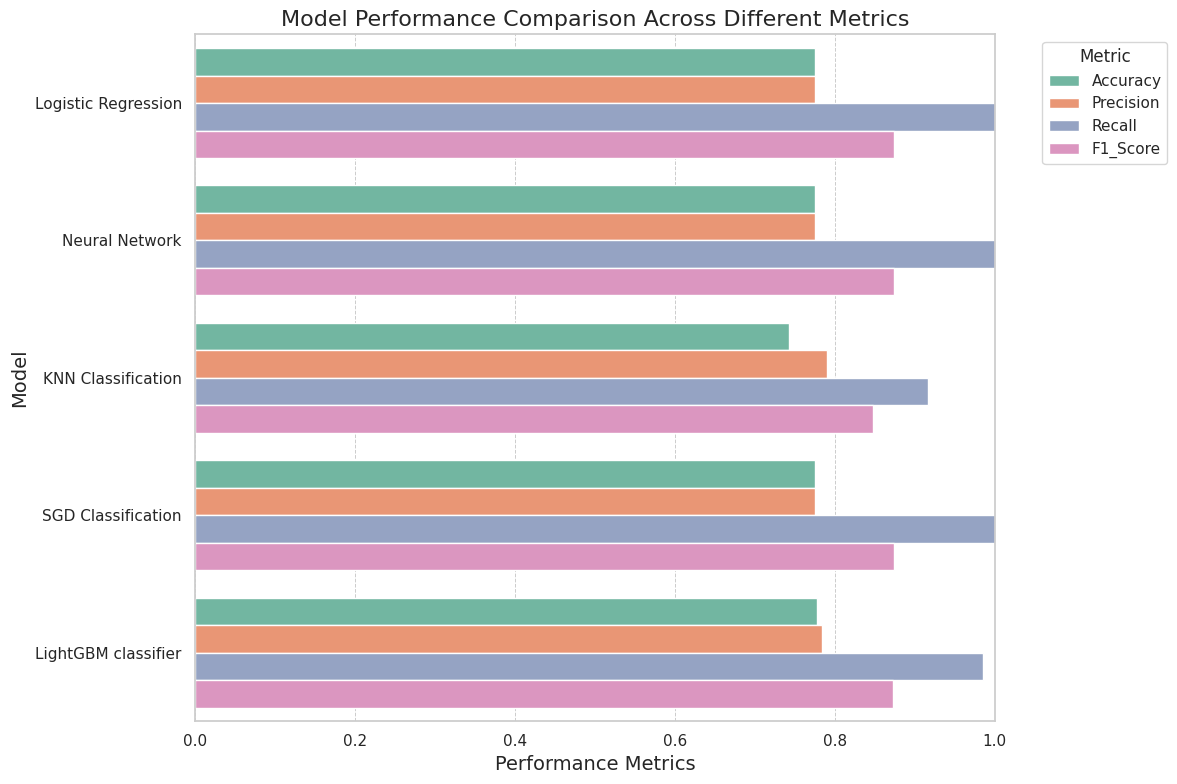

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# DataFrame with model performance metrics
models_performance = pd.DataFrame({
    'Model': ['Logistic Regression', 'Neural Network', 'KNN Classification', 'SGD Classification', 'LightGBM classifier'],
    'Accuracy': [0.7755, 0.7755, 0.7424, 0.7755, 0.7771941432898349],
    'Precision': [0.7755, 0.7755, 0.7899, 0.7755, 0.7836172789518312],
    'Recall': [1.0, 1.0, 0.9162, 1.0, 0.9845691263898965],
    'F1_Score': [0.8736, 0.8736, 0.8471, 0.8736, 0.8726742581334617]
})

# Melting the DataFrame to have a column for metrics and their values
models_performance_melted = models_performance.melt(id_vars=['Model'], var_name='Metric', value_name='Value')

# Plotting
plt.figure(figsize=(12, 8))
sns.barplot(x='Value', y='Model', hue='Metric', data=models_performance_melted, palette='Set2')
plt.title('Model Performance Comparison Across Different Metrics', fontsize=16)
plt.xlabel('Performance Metrics', fontsize=14)
plt.ylabel('Model', fontsize=14)
plt.xlim(0, 1)
plt.legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='x', linestyle='--', linewidth=0.7)
plt.tight_layout()
plt.show()

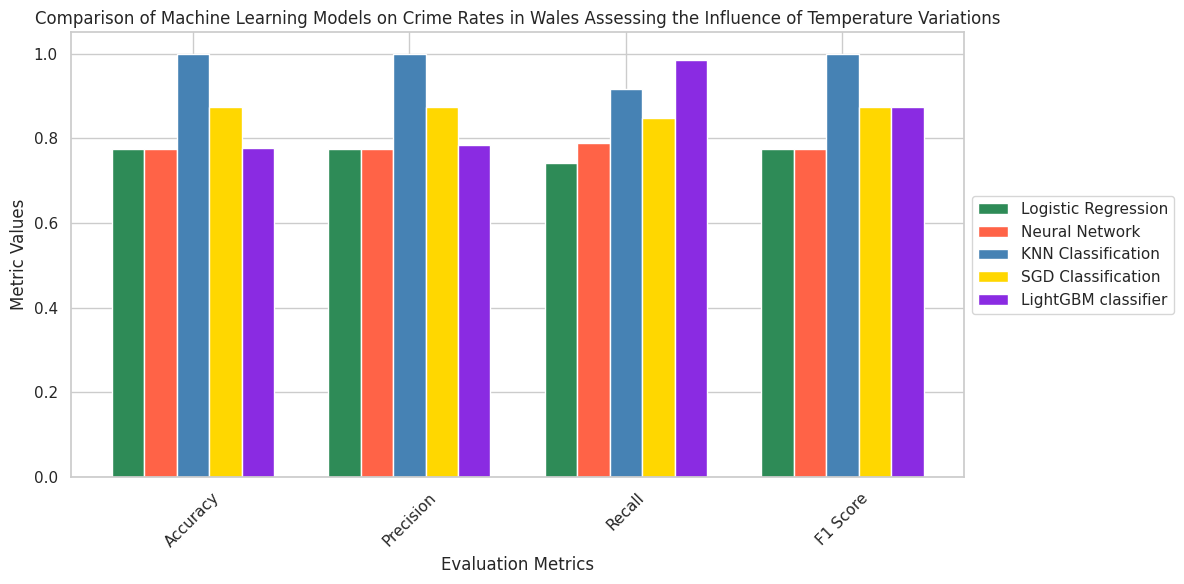

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Metric categories
categories = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
# Values for each model [Logistic Regression, Neural Network, KNN Classification, SGD Classification, LightGBM classifier]
values = np.array([
    [0.7755, 0.7755, 0.7424, 0.7755], #Accuracy
    [0.7755, 0.7755, 0.7899, 0.7755], #Precision
    [1.0, 1.0, 0.9162, 1.0], #Recall
    [0.8736, 0.8736, 0.8471, 0.8736], #F1-Score
    [0.7772, 0.7836, 0.9846, 0.8727] #LightGBM Metrics
])

n_categories = len(categories)
x = np.arange(n_categories)

fig, ax = plt.subplots(figsize=(12, 6))
bar_width = 0.15
models = ['Logistic Regression', 'Neural Network', 'KNN Classification', 'SGD Classification', 'LightGBM classifier']

# New set of diverse colors for each model
colors = ['#2E8B57', '#FF6347', '#4682B4', '#FFD700', '#8A2BE2']  # Sea Green, Tomato, Steel Blue, Gold, Blue Violet

for i in range(len(models)):
    ax.bar(x + i * bar_width, values[i], width=bar_width, label=models[i], color=colors[i])

ax.set_xlabel('Evaluation Metrics')
ax.set_ylabel('Metric Values')
ax.set_title('Comparison of Machine Learning Models on Crime Rates in Wales Assessing the Influence of Temperature Variations')
ax.set_xticks(x + bar_width * (len(models) - 1) / 2)
ax.set_xticklabels(categories)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))  # Adjusts the legend position

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

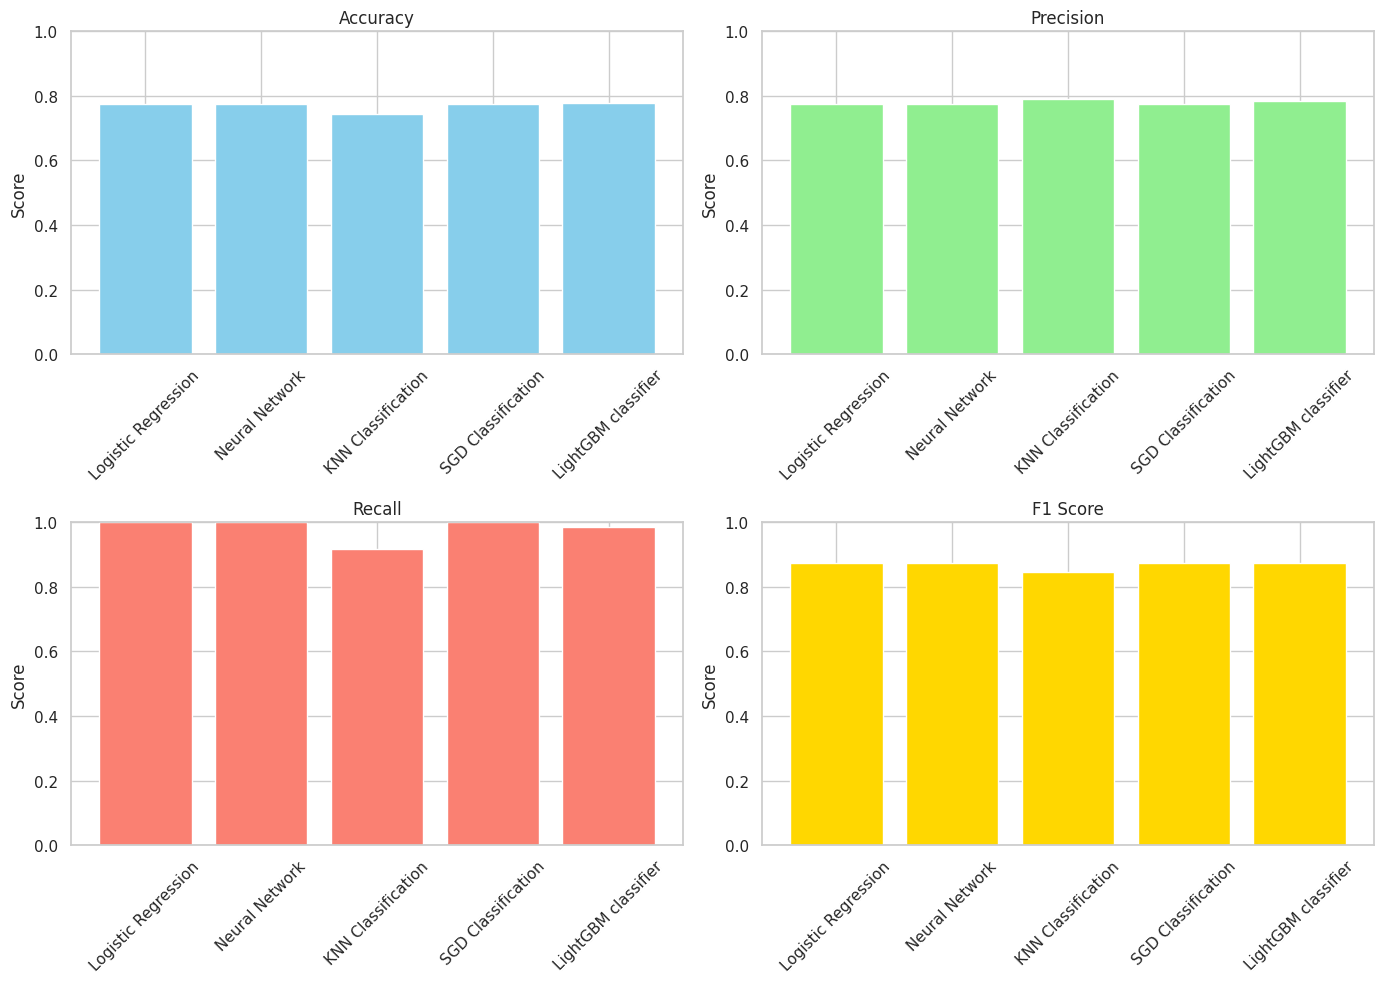

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Model names
models = ['Logistic Regression', 'Neural Network', 'KNN Classification', 'SGD Classification', 'LightGBM classifier']

# Performance metrics
accuracy = [0.7755, 0.7755, 0.7424, 0.7755, 0.7771941432898349]
precision = [0.7755, 0.7755, 0.7899, 0.7755, 0.7836172789518312]
recall = [1.0, 1.0, 0.9162, 1.0, 0.9845691263898965]
f1_score = [0.8736, 0.8736, 0.8471, 0.8736, 0.8726742581334617]

# Creating subplots for each metric
fig, axs = plt.subplots(2, 2, figsize=(14, 10))  # Increased figure size

# Accuracy plot
axs[0, 0].bar(models, accuracy, color='skyblue')
axs[0, 0].set_title('Accuracy')
axs[0, 0].set_ylim([0, 1])
axs[0, 0].set_ylabel('Score')
axs[0, 0].tick_params(axis='x', rotation=45)  # Rotating labels

# Precision plot
axs[0, 1].bar(models, precision, color='lightgreen')
axs[0, 1].set_title('Precision')
axs[0, 1].set_ylim([0, 1])
axs[0, 1].set_ylabel('Score')
axs[0, 1].tick_params(axis='x', rotation=45)  # Rotating labels

# Recall plot
axs[1, 0].bar(models, recall, color='salmon')
axs[1, 0].set_title('Recall')
axs[1, 0].set_ylim([0, 1])
axs[1, 0].set_ylabel('Score')
axs[1, 0].tick_params(axis='x', rotation=45)  # Rotating labels

# F1 Score plot
axs[1, 1].bar(models, f1_score, color='gold')
axs[1, 1].set_title('F1 Score')
axs[1, 1].set_ylim([0, 1])
axs[1, 1].set_ylabel('Score')
axs[1, 1].tick_params(axis='x', rotation=45)  # Rotating labels

plt.tight_layout()
plt.show()